In [1]:
import pandas as pd
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import mannwhitneyu
from tueplots import bundles
from scipy.spatial import cKDTree
from scipy.stats import levene

pd.set_option('display.max_columns', None)

# Upload and transform the data
We have 2 datasets - initial events for riding and a dataset with all possible matches. First I upload them and then join the most probable ride info to the initial events dataset

In [2]:
# reading matching dataset
df = pd.read_parquet(
    "matching/matching_candidates_scored.parquet"
)
df.head()

,d_idx,f_idx,provider,vehicle_type_id,d_lat,d_lon,f_lat,f_lon,d_time,f_time,d_range_km,f_range_km,delta_t_hours,range_consumed,opt_route_km,opt_route_min,speed,log_p_distance,log_p_speed,log_p_range,score,haversine_km,prob,prob_null,prob_forward,prob_backward
0,171071,173445,bolt_basel,BLT:VehicleType:e92dc79f-736d-5eca-9ff4-180665...,47.559498,7.598561,47.537254,7.570603,2025-10-26 14:10:06.891088,2025-10-26 14:27:06.883382,13.2,9.600000,0.283331,3.6,3.68,12.000000,12.988334,-2.502355,-2.203296,-1.685448,-6.391099,NaN,9.997973e-01,0.000203,9.997973e-01,9.154952e-01
1,171713,177179,bolt_basel,BLT:VehicleType:e92dc79f-736d-5eca-9ff4-180665...,47.578182,7.589325,47.513931,7.620455,2025-10-26 14:15:06.910183,2025-10-26 14:52:06.898922,23.6,22.799999,0.616664,0.8,8.50,27.299999,13.783854,-4.937281,-2.163429,-5.086204,-12.186913,NaN,9.350702e-04,0.001164,9.350702e-04,4.159073e-02
2,171713,173443,bolt_basel,BLT:VehicleType:e92dc79f-736d-5eca-9ff4-180665...,47.578182,7.589325,47.563847,7.591785,2025-10-26 14:15:06.910183,2025-10-26 14:27:06.883382,23.6,8.400000,0.199993,15.2,2.12,7.000000,10.600394,-1.496594,-2.633249,-32.344440,-36.474281,NaN,6.174466e-19,0.001164,6.174466e-19,3.588094e-07
3,171713,180306,bolt_basel,BLT:VehicleType:e92dc79f-736d-5eca-9ff4-180665...,47.578182,7.589325,47.552078,7.621399,2025-10-26 14:15:06.910183,2025-10-26 15:13:06.871626,23.6,5.200000,0.966656,18.4,5.31,17.200001,5.493165,-3.434094,-5.115246,-13.601135,-22.150475,NaN,7.360793e-10,0.001164,7.360793e-10,4.914604e-04
4,171713,174099,bolt_basel,BLT:VehicleType:e92dc79f-736d-5eca-9ff4-180665...,47.578182,7.589325,47.563206,7.588843,2025-10-26 14:15:06.910183,2025-10-26 14:32:06.902328,23.6,18.400000,0.283331,5.2,1.86,6.200000,6.564756,-1.327730,-4.417964,-3.411419,-9.157114,NaN,4.014666e-01,0.001164,4.014666e-01,9.999986e-01


In [3]:
# getting only one most probable match for every ride
best_matches = df.loc[df.groupby('d_idx')['prob'].idxmax()]

In [4]:
#reading file with original events
df_init = pd.read_parquet(
    "vehicle_events_export.parquet"
)

df_init.head()

,id,vehicle_id,timestamp,provider,lat,lon,is_reserved,is_disabled,vehicle_type_id,current_range_meters,current_fuel_percent,last_reported,pricing_plan_id,change_types,distance_moved_meters,disappeared,first_seen,is_maintenance,is_id_reset,is_temporary_disappearance,closest_public_transport_distance_m,closest_public_transport_mode,closest_public_transport_name,recalibrated_current_range_meters,clustered_provider,city
0,1,DOA:Vehicle:099bebbb-2535-40cf-8021-f6ea89a8044a,2025-10-25 16:07:15.888101,dott_boblingen,48.676161,9.036716,0,0,DOA:VehicleType:dott_scooter,11052.0,0.36,1.761408e+09,DOA:PricingPlan:214002b9-79e8-4b63-98ec-83814e...,"[""first_seen""]",NaN,False,True,False,False,False,423.814405,bus,Tannenberg,11052.0,NaN,Stuttgart
1,2,DOA:Vehicle:31908c5d-342a-4b48-be79-2218fe1e692a,2025-10-25 16:07:15.888101,dott_boblingen,48.689552,8.991393,0,0,DOA:VehicleType:dott_scooter,28244.0,0.92,1.761407e+09,DOA:PricingPlan:214002b9-79e8-4b63-98ec-83814e...,"[""first_seen""]",NaN,False,True,False,False,False,64.803460,bus,Melli-Beese-Straße,28244.0,NaN,Stuttgart
2,3,DOA:Vehicle:b004e75b-5066-41ab-b723-f95ffef43a22,2025-10-25 16:07:15.888101,dott_boblingen,48.710133,9.001241,0,0,DOA:VehicleType:dott_scooter,19955.0,0.65,1.761408e+09,DOA:PricingPlan:214002b9-79e8-4b63-98ec-83814e...,"[""first_seen""]",NaN,False,True,False,False,False,178.964149,bus,Sindelfingen DOMO,19955.0,NaN,Stuttgart
3,4,DOA:Vehicle:85ee997d-84f1-463a-944b-199f4d894f16,2025-10-25 16:07:15.888101,dott_boblingen,48.669899,9.004707,0,0,DOA:VehicleType:dott_scooter,27937.0,0.91,1.761408e+09,DOA:PricingPlan:214002b9-79e8-4b63-98ec-83814e...,"[""first_seen""]",NaN,False,True,False,False,False,25.679197,bus,Diezenhalde Zentrum,27937.0,NaN,Stuttgart
4,5,DOA:Vehicle:c653f9df-0742-4191-bcb3-a2be931088be,2025-10-25 16:07:15.888101,dott_boblingen,48.684032,9.012866,0,0,DOA:VehicleType:dott_scooter,27323.0,0.89,1.761408e+09,DOA:PricingPlan:214002b9-79e8-4b63-98ec-83814e...,"[""first_seen""]",NaN,False,True,False,False,False,288.238891,bus,Klaffensteinstraße,27323.0,NaN,Stuttgart


In [5]:
# dataset clean-up

df_init['timestamp'] = pd.to_datetime(df_init['timestamp'])
df_init['date'] = df_init['timestamp'].dt.date
df_init['hour'] = df_init['timestamp'].dt.hour
df_init['day_of_week'] = df_init['timestamp'].dt.day_name()

In [6]:
# merge with main_df to get full event details
trips = df_init.merge(
    best_matches[['d_idx', 'f_idx', 'opt_route_km', 'opt_route_min', 'speed', 'prob', 'prob_null', 'd_range_km', 'f_range_km', 'range_consumed']],
    left_index=True,
    right_on='d_idx',
    how='left'
)

confident = best_matches[best_matches['prob_null'] < 0.5] # filter confident matches



In [7]:
# filter only real disappearance events

trips = trips[(trips['disappeared'] == 1) & (trips['first_seen'] == False) & (trips['is_maintenance'] == False)  & (trips['is_id_reset'] == False) & (trips['is_temporary_disappearance'] == False)]


# Parse historical hourly weather data based on lat and lon of major cities in the dataset.

In [8]:
# Parsing weather data
def fetch_weather_data_open_meteo(lat, lon, start_date, end_date):
    base_url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        'latitude': lat,
        'longitude': lon,
        'start_date': start_date,
        'end_date': end_date,
        'hourly': [
            'temperature_2m',
            'precipitation',
            'rain',
            'snowfall',
            'windspeed_10m',
            'winddirection_10m',
            'cloudcover',
            'relativehumidity_2m',
            'pressure_msl'
        ],
        'timezone': 'Europe/Berlin'
    }
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"Error fetching weather data: {e}")
        return None


start_date = trips['timestamp'].min().strftime('%Y-%m-%d')
end_date = trips['timestamp'].max().strftime('%Y-%m-%d')

print(f"Data range: {start_date} to {end_date}")

locations = {
    'Saarbrucken': {'lat': 49.2354, 'lon': 6.9969},
    'Stuttgart': {'lat': 48.7758, 'lon': 9.1829},
    'Heilbronn': {'lat': 49.1427, 'lon': 9.2109},
    'Zurich': {'lat': 47.3769, 'lon': 8.5417},
    'Ulm': {'lat': 48.4011, 'lon': 9.9876},
    'Karlsruhe': {'lat': 49.0069, 'lon': 8.4037},
    'Mainz': {'lat': 49.9929, 'lon': 8.2473},
    'Mannheim': {'lat': 49.4878, 'lon': 8.4662},
    'Reutlingen': {'lat': 48.4916, 'lon': 9.2040},
    'Friedrichshafen': {'lat': 47.6510, 'lon': 9.4787},
    'Kaiserslautern': {'lat': 49.4400, 'lon': 7.7491},
    'Heidelberg': {'lat': 49.4077, 'lon': 8.6908},
    'Ludwigsburg': {'lat': 48.8950, 'lon': 9.1911},
    'Bregenz': {'lat': 47.5037, 'lon': 9.7471},
    'Boblingen': {'lat': 48.6853, 'lon': 9.0160},
    'Winterthur': {'lat': 47.4992, 'lon': 8.7241},
    'Basel': {'lat': 47.5596, 'lon': 7.5886},
    'Tuebingen': {'lat': 48.5216, 'lon': 9.0570},
    'Lindau': {'lat': 47.5480, 'lon': 9.6773},
    'Villingen': {'lat': 48.0686, 'lon': 8.4805},
    'Uberlingen': {'lat': 47.7691, 'lon': 9.1758},
    'Freiburg': {'lat': 47.9990, 'lon': 7.8421},
    'Konstanz': {'lat': 47.6770, 'lon': 9.1770},
    'Renningen': {'lat': 48.7714, 'lon': 8.9083},
    'Pforzheim': {'lat': 48.8922, 'lon': 8.6945},
    'Goppingen': {'lat': 48.7036, 'lon': 9.6509},
    'Schwabisch Gmünd': {'lat': 48.7927, 'lon': 9.7857},
    'Schwenningen': {'lat': 48.0686, 'lon': 8.4805},  
    'Malmsheim': {'lat': 48.7412, 'lon': 8.8883},
    'Gmund': {'lat': 47.7073, 'lon': 11.6991}, 
    'St Gallen': {'lat': 47.4236, 'lon': 9.3767}
}

weather_data_list = []

for city, coords in locations.items():
    print(f"Fetching weather data for {city}...")
    weather_json = fetch_weather_data_open_meteo(
        coords['lat'], 
        coords['lon'], 
        start_date, 
        end_date
    )
    
    if weather_json and 'hourly' in weather_json:
        df_weather = pd.DataFrame(weather_json['hourly'])
        df_weather['city'] = city
        df_weather['lat'] = coords['lat']
        df_weather['lon'] = coords['lon']
        weather_data_list.append(df_weather)

df_weather_all = pd.concat(weather_data_list, ignore_index=True)
df_weather_all['time'] = pd.to_datetime(df_weather_all['time'])

print("\nWeather Data Shape:", df_weather_all.shape)
print(df_weather_all.head())

Data range: 2025-10-26 to 2026-01-18
Fetching weather data for Saarbrucken...
Fetching weather data for Stuttgart...
Fetching weather data for Heilbronn...
Fetching weather data for Zurich...
Fetching weather data for Ulm...
Fetching weather data for Karlsruhe...
Fetching weather data for Mainz...
Fetching weather data for Mannheim...
Fetching weather data for Reutlingen...
Fetching weather data for Friedrichshafen...
Fetching weather data for Kaiserslautern...
Fetching weather data for Heidelberg...
Fetching weather data for Ludwigsburg...
Fetching weather data for Bregenz...
Fetching weather data for Boblingen...
Fetching weather data for Winterthur...
Fetching weather data for Basel...
Fetching weather data for Tuebingen...
Fetching weather data for Lindau...
Fetching weather data for Villingen...
Fetching weather data for Uberlingen...
Fetching weather data for Freiburg...
Fetching weather data for Konstanz...
Fetching weather data for Renningen...
Fetching weather data for Pforzhe

In [9]:
#Assign weather stations to events based on coordinates of weather stations and scooter events

def assign_nearest_weather_station(scooter_df, weather_locations):

    weather_coords = np.array([[loc['lat'], loc['lon']] 
                               for loc in weather_locations.values()])
    weather_cities = list(weather_locations.keys())
    tree = cKDTree(weather_coords)
    
    scooter_coords = scooter_df[['lat', 'lon']].values
    distances, indices = tree.query(scooter_coords)
    
    scooter_df['nearest_city'] = [weather_cities[i] for i in indices]
    scooter_df['weather_distance_km'] = distances * 111  # approx conversion to km
    
    return scooter_df
trips = assign_nearest_weather_station(trips, locations)

In [10]:
#Merge weather data and scooter data

def merge_weather_with_scooters(scooter_df, weather_df):

    scooter_df = scooter_df.copy()
    scooter_df['timestamp'] = pd.to_datetime(scooter_df['timestamp'], utc=True)
    scooter_df['timestamp_hour'] = scooter_df['timestamp'].dt.floor('H')

    weather_df = weather_df.copy()
    weather_df['time'] = pd.to_datetime(weather_df['time']).dt.tz_localize('UTC')
    weather_df = weather_df.rename(columns={'time': 'timestamp_hour'})

    merged_df = scooter_df.merge(
        weather_df,
        left_on=['timestamp_hour', 'nearest_city'],
        right_on=['timestamp_hour', 'city'],
        how='left'
    )

    return merged_df

df_merged = merge_weather_with_scooters(trips, df_weather_all)

C:\Users\erike\AppData\Local\Temp\ipykernel_102432\641031021.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  scooter_df['timestamp_hour'] = scooter_df['timestamp'].dt.floor('H')


In [11]:
#Get rid of NaN

df_filtered = df_merged[df_merged['opt_route_km'].notna()]

In [12]:
#Filter only for columns that I need
df_weather = df_filtered[['id', 'vehicle_id','timestamp', 'date',
       'hour', 'day_of_week','provider', 'lat_x', 'lon_x', 'opt_route_km', 'opt_route_min','d_range_km',
       'f_range_km', 'range_consumed',  'speed',  'nearest_city', 'weather_distance_km', 'temperature_2m','rain', 'snowfall',
       'windspeed_10m', 'precipitation', 'winddirection_10m', 'cloudcover',
       'relativehumidity_2m', 'pressure_msl']]

## feature ingeneering - trying to combine weather features into a more complex single index

Wind Chill Index - https://www.weather.gov/safety/cold-wind-chill-chart
Cannot use it as is, have to make adjustments for km/h and celsius 

Heat index - https://www.weather.gov/ama/heatindex. It is only meaningful for warm temperatures (typically > 27°C / 80°F) and moderate-to-high humidity, which we do not have in our dataset -> only focus on wind chill index


### Original Wind Chill Formula (Fahrenheit + mph)

$$
WC_F = 35.74 + 0.6215,T_F - 35.75,V^{0.16} + 0.4275,T_F,V^{0.16}
$$

Where:

* ( WC_F ) = wind chill in °F
* ( T_F ) = air temperature in °F
* ( V ) = wind speed in mph

### Unit Conversion

Convert **Celsius → Fahrenheit** and **km/h → mph**:

$$
T_F = T_C \cdot \frac{9}{5} + 32
$$

$$
V_{\text{mph}} = V_{\text{km/h}} \cdot 0.621371
$$


### Wind Chill Formula in Celsius + km/h

Substitute the conversions into the original formula and then convert the result back to Celsius:

[
\begin{align*}
WC_C &= (WC_F - 32) \cdot \frac{5}{9} \
WC_F &= 35.74 + 0.6215,T_F - 35.75,V_{\text{mph}}^{0.16} + 0.4275,T_F,V_{\text{mph}}^{0.16} \
T_F &= T_C \cdot \frac{9}{5} + 32 \
V_{\text{mph}} &= V_{\text{km/h}} \cdot 0.621371
\end{align*}
]

### Final Celsius wind chill

$$
WC_C = \left[35.74 + 0.6215 \left(T_C \cdot \frac{9}{5} + 32\right) - 35.75 \left(V_{\text{km/h}} \cdot 0.621371\right)^{0.16} + 0.4275 \left(T_C \cdot \frac{9}{5} + 32\right) \left(V_{\text{km/h}} \cdot 0.621371\right)^{0.16} - 32 \right] \cdot \frac{5}{9}
$$


In [13]:
def wind_chill_celsius(T_C, V_kmh):

    T_F = T_C * 9/5 + 32
    V_mph = V_kmh * 0.621371

    WC_F = 35.74 + 0.6215*T_F - 35.75*V_mph**0.16 + 0.4275*T_F*V_mph**0.16
    
    WC_C = (WC_F - 32) * 5/9
    return WC_C
df_weather['wind_chill'] = wind_chill_celsius(df_weather['temperature_2m'], df_weather['windspeed_10m'])


C:\Users\erike\AppData\Local\Temp\ipykernel_102432\1866085602.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['wind_chill'] = wind_chill_celsius(df_weather['temperature_2m'], df_weather['windspeed_10m'])


In [14]:
#Create categories, sorry but i just ignore the warnings 

def create_features(df):

    if 'timestamp' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Temporal features
    if 'day_of_week' in df.columns:
        df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
    
    
    # Temperature categories
    if 'temperature_2m' in df.columns:
        df['temp_category'] = pd.cut(
            df['temperature_2m'],
            bins=[-np.inf, 0, 10, np.inf],
            labels=['Freezing', 'Cold', 'Moderate-Warm']
        )
    #Wind-chill categories
    if 'wind_chill' in df.columns:
        df_weather['wind_chill_category'] = pd.cut(
                df_weather['wind_chill'],
                bins=[-np.inf, 0, 10, np.inf],
                labels=['Freezing', 'Cold', 'Moderate-Warm']
            )

    # Rain categories
    if 'precipitation' in df.columns:
        df['rain_category'] = pd.cut(
            df['precipitation'],
            bins=[-0.1, 0, np.inf],
            labels=['No Rain', 'Rain']
        )
    
    # Wind speed categories
    if 'windspeed_10m' in df.columns:
        df['wind_category'] = pd.cut(
            df['windspeed_10m'],
            bins=[-0.1, 5, 10, 15, np.inf],
            labels=['Calm', 'Light Wind', 'Moderate Wind', 'Strong Wind']
        )
    
    # Pressure categories
    if 'pressure_msl' in df.columns:
        df['pressure_category'] = pd.cut(
            df['pressure_msl'],
            bins=[-np.inf, 980, 1000, 1020, 1040, np.inf],
            labels=['Very Low', 'Low', 'Normal', 'High', 'Very High']
        )
    
    # Wind direction categories
    if 'winddirection_10m' in df.columns:
        df['winddirection_category'] = pd.cut(
            df['winddirection_10m'],
            bins=[-1, 22.5, 67.5, 112.5, 157.5, 202.5, 247.5, 292.5, 337.5, 360],
            labels=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N2']
        )
    
    # Cloud cover categories
    if 'cloudcover' in df.columns:
        df['cloudcover_category'] = pd.cut(
            df['cloudcover'],
            bins=[-1, 10, 30, 70, 90, 101],
            labels=['Clear', 'Partly Cloudy', 'Cloudy', 'Mostly Cloudy', 'Overcast']
        )
    
    # Relative humidity categories
    if 'relativehumidity_2m' in df.columns:
        df['humidity_category'] = pd.cut(
            df['relativehumidity_2m'],
            bins=[-1, 30, 50, 70, 90, 101],
            labels=['Very Dry', 'Dry', 'Comfortable', 'Humid', 'Very Humid']
        )
    
    # Snowfall categories
    if 'snowfall' in df.columns:
        df['snowfall_category'] = pd.cut(
            df['snowfall'],
            bins=[-0.1, 0, 0.5, 2, 5, np.inf],
            labels=['No Snow', 'Very Light', 'Light', 'Moderate', 'Heavy']
        )
    
    # Usage metrics 
    if 'disappeared' in df.columns:
        df['is_used'] = df['disappeared'].astype(int)
    elif 'change_types' in df.columns:
        # If there's a change_types column that indicates usage
        df['is_used'] = (df['change_types'] == 'used').astype(int)
    else:
        # Fallback: assume all records are rides
        df['is_used'] = 1
    
    return df

df_weather = create_features(df_weather)

print("\nFeature Engineering Complete!")
print("\nNew columns:")
print(df_weather.columns.tolist())

C:\Users\erike\AppData\Local\Temp\ipykernel_102432\999920075.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
C:\Users\erike\AppData\Local\Temp\ipykernel_102432\999920075.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_category'] = pd.cut(
C:\Users\erike\AppData\Local\Temp\ipykernel_102432\999920075.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r


Feature Engineering Complete!

New columns:
['id', 'vehicle_id', 'timestamp', 'date', 'hour', 'day_of_week', 'provider', 'lat_x', 'lon_x', 'opt_route_km', 'opt_route_min', 'd_range_km', 'f_range_km', 'range_consumed', 'speed', 'nearest_city', 'weather_distance_km', 'temperature_2m', 'rain', 'snowfall', 'windspeed_10m', 'precipitation', 'winddirection_10m', 'cloudcover', 'relativehumidity_2m', 'pressure_msl', 'wind_chill', 'is_weekend', 'temp_category', 'wind_chill_category', 'rain_category', 'wind_category', 'pressure_category', 'winddirection_category', 'cloudcover_category', 'humidity_category', 'snowfall_category', 'is_used']


C:\Users\erike\AppData\Local\Temp\ipykernel_102432\999920075.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['humidity_category'] = pd.cut(
C:\Users\erike\AppData\Local\Temp\ipykernel_102432\999920075.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['snowfall_category'] = pd.cut(
C:\Users\erike\AppData\Local\Temp\ipykernel_102432\999920075.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


# EDA

In [15]:
#Destributions

def plot_category_share(df, col):
    shares = df[col].value_counts(normalize=True).sort_index()
    shares.plot(kind="bar")
    plt.title(f"Distribution of {col}")
    plt.ylabel("Share of observations")
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [16]:
#Ratios of weather and rides

def plot_weather_adjusted(df, weather_column):
    
    # Get date from timestamp
    if 'date' in df.columns:
        date_col = 'date'
    elif 'timestamp' in df.columns:
        df['date'] = pd.to_datetime(df['timestamp']).dt.date
        date_col = 'date'
    else:
        raise ValueError("Need date or timestamp column")
    
    daily_weather = df.drop_duplicates(subset=[date_col, weather_column])
    weather_freq = daily_weather[weather_column].value_counts(normalize=True)
    ride_dist = df[weather_column].value_counts(normalize=True)
    

    comparison = pd.DataFrame({
        'weather_freq': weather_freq,
        'ride_share': ride_dist
    }).fillna(0)
    
   
    comparison['ratio'] = comparison['ride_share'] / comparison['weather_freq']
    comparison['ratio'] = comparison['ratio'].replace([np.inf, -np.inf], np.nan).fillna(0)
    
    comparison = comparison.sort_values('ratio', ascending=False)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    bars1 = ax1.bar(range(len(comparison)), comparison['weather_freq'] * 100, 
                   color='lightblue', alpha=0.8)
    ax1.set_xticks(range(len(comparison)))
    ax1.set_xticklabels(comparison.index, rotation=45, ha='right')
    ax1.set_xlabel(weather_column)
    ax1.set_ylabel('Percentage of Days (%)')
    ax1.set_title(f'Weather Frequency by {weather_column}')
    ax1.grid(True, alpha=0.3, axis='y')
    
    for i, v in enumerate(comparison['weather_freq'] * 100):
        ax1.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=9)
    
    bars2 = ax2.bar(range(len(comparison)), comparison['ride_share'] * 100,
                   color='salmon', alpha=0.8)
    ax2.set_xticks(range(len(comparison)))
    ax2.set_xticklabels(comparison.index, rotation=45, ha='right')
    ax2.set_xlabel(weather_column)
    ax2.set_ylabel('Percentage of Rides (%)')
    ax2.set_title(f'Ride Share by {weather_column}')
    ax2.grid(True, alpha=0.3, axis='y')
    
    for i, v in enumerate(comparison['ride_share'] * 100):
        ax2.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=9)
    
    colors = ['green' if ratio > 1 else 'red' for ratio in comparison['ratio']]
    bars3 = ax3.bar(range(len(comparison)), comparison['ratio'], 
                   color=colors, alpha=0.7)
    
    ax3.set_xticks(range(len(comparison)))
    ax3.set_xticklabels(comparison.index, rotation=45, ha='right')
    ax3.set_xlabel(weather_column)
    ax3.set_ylabel('Ratio (Rides / Weather)')
    ax3.set_title(f'Ride-to-Weather Ratio by {weather_column}\n>1 = More rides than expected')
    ax3.grid(True, alpha=0.3, axis='y')
    
    ax3.axhline(y=1, color='black', linestyle='--', linewidth=1, alpha=0.7,
               label='Expected (ratio = 1)')
    ax3.legend()
    
    for i, v in enumerate(comparison['ratio']):
        label = f"{v:.2f}"
        if v > 10:  
            label = f"{v:.1f}"
        
        y_position = v + 0.05 if v >= 0 else v - 0.15
        ha_position = 'center'
        
        ax3.text(i, y_position, label, ha=ha_position, fontsize=9, fontweight='bold')
    
    total_days = daily_weather[date_col].nunique()
    total_rides = len(df)
    
    plt.suptitle(f'Weather Frequency vs Ride Distribution vs Ratio\n'
                f'Total Days: {total_days:,} | Total Rides: {total_rides:,}', 
                fontsize=14, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Analysis for: {weather_column}")
    print(f"Total unique days: {total_days}")
    print(f"Total rides: {total_rides}")
    
    print("\n" + "="*70)
    print("KEY INTERPRETATION:")
    print("- Ratio > 1: More rides than expected given weather frequency")
    print("- Ratio < 1: Fewer rides than expected given weather frequency")
    print("- Ratio = 1: Rides exactly match weather frequency")
    print("="*70 + "\n")
    
    print("Detailed comparison (sorted by ratio, highest to lowest):")
    print("-" * 70)
    
    for idx, (weather_condition, row) in enumerate(comparison.iterrows(), 1):
        ratio = row['ratio']
        ride_pct = row['ride_share'] * 100
        weather_pct = row['weather_freq'] * 100
        
        if ratio > 1.5:
            status = "STRONGLY PREFERRED"
            symbol = "↑↑"
        elif ratio > 1.1:
            status = "PREFERRED"
            symbol = "↑"
        elif ratio < 0.5:
            status = "STRONGLY AVOIDED"
            symbol = "↓↓"
        elif ratio < 0.9:
            status = "AVOIDED"
            symbol = "↓"
        else:
            status = "NEUTRAL"
            symbol = "→"
        
        print(f"{idx}. {weather_condition} {symbol}")
        print(f"   Weather: {weather_pct:5.1f}% of days")
        print(f"   Rides:   {ride_pct:5.1f}% of rides")
        print(f"   Ratio:   {ratio:5.2f} ({status})")
        print()
    
    return comparison

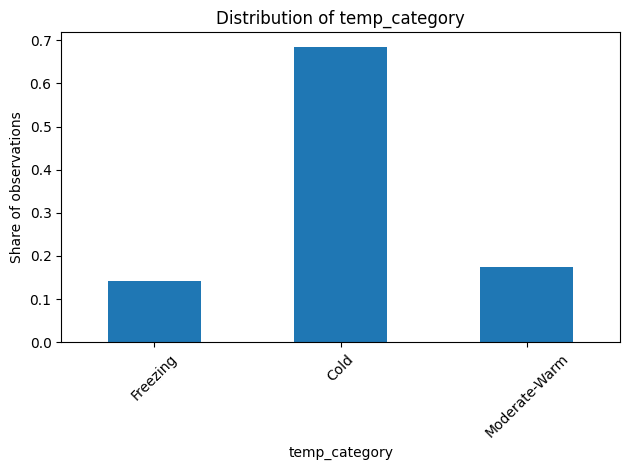

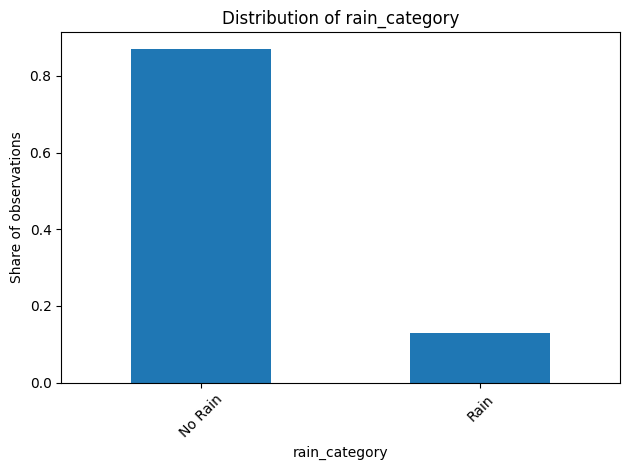

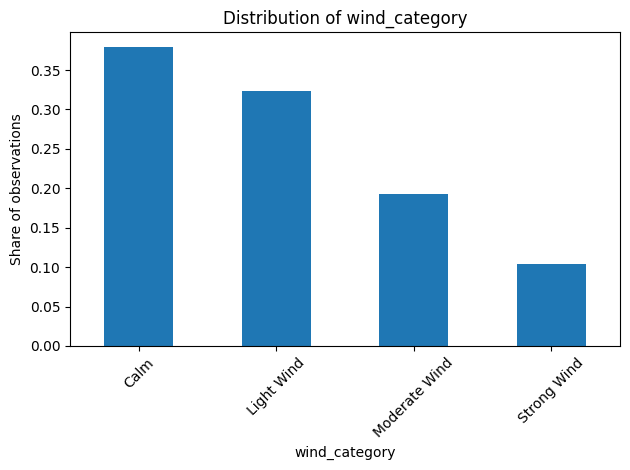

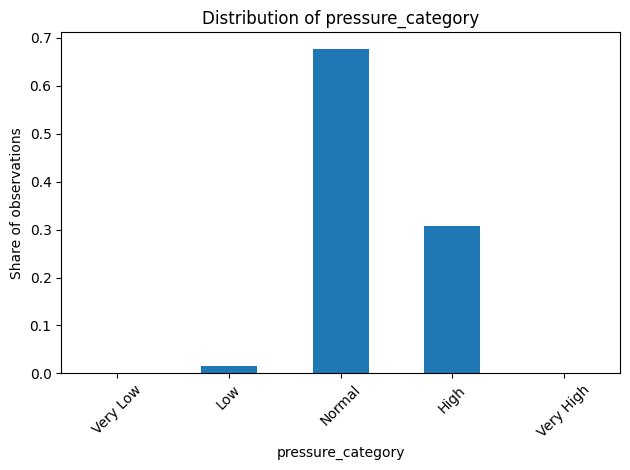

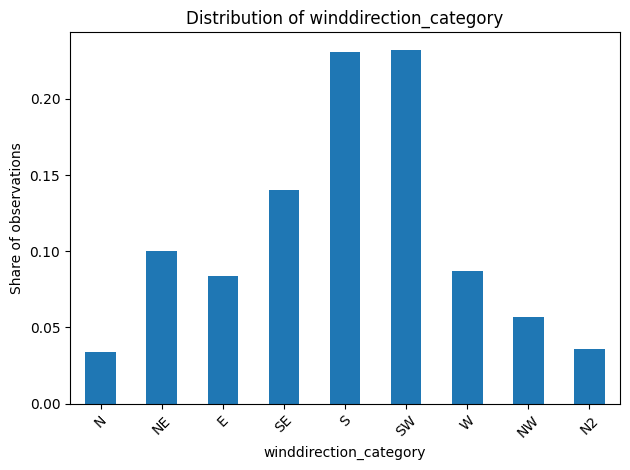

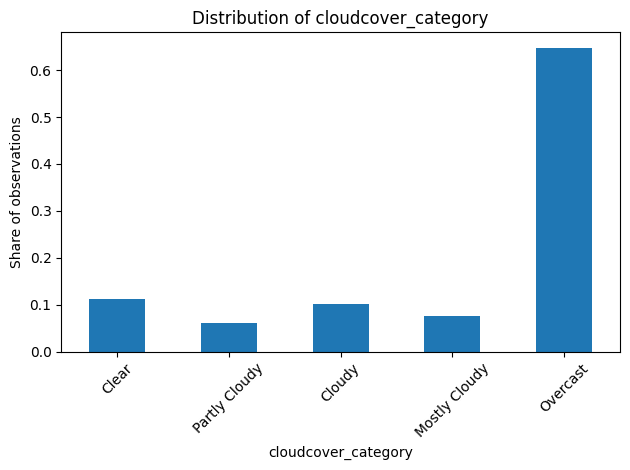

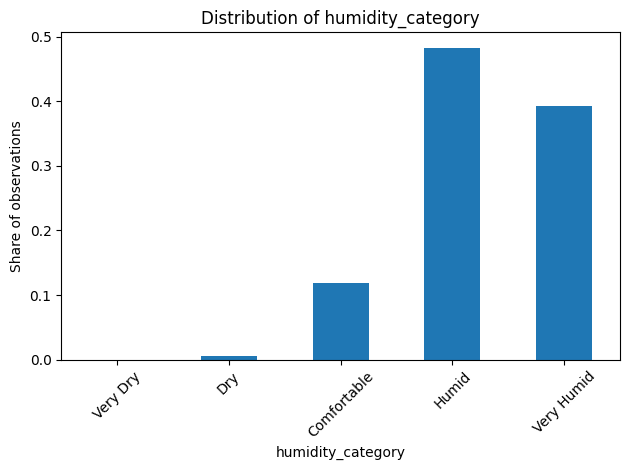

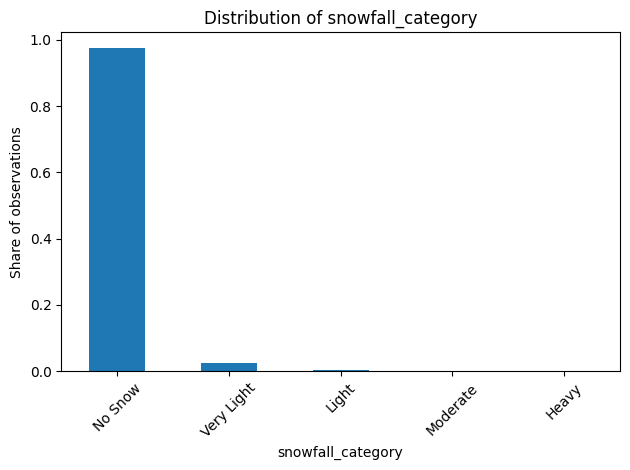

In [17]:
for i in ['temp_category', 'rain_category', 'wind_category',
       'pressure_category', 'winddirection_category', 'cloudcover_category',
       'humidity_category', 'snowfall_category']:
    plot_category_share(df_weather, i)
#distributions are obv very skewed, since we only collected data in the colder season

In [18]:
def plot_weather_hourly_ratio(df, weather_column, date_col="date", hour_col="hour"):
    df = df.copy()

    weather_hourly = df[[date_col, hour_col, weather_column]].drop_duplicates()
    weather_share = weather_hourly[weather_column].value_counts(normalize=True)

    ride_share = df[weather_column].value_counts(normalize=True)

    comparison = pd.DataFrame({
        "weather_share": weather_share,
        "ride_share": ride_share
    }).fillna(0)
    comparison["ratio"] = comparison["ride_share"] / comparison["weather_share"]
    comparison = comparison.replace([np.inf, -np.inf], np.nan).fillna(0)
    comparison = comparison.sort_values("ratio", ascending=False)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    ax1.bar(comparison.index, comparison["weather_share"] * 100,
            color="lightblue", alpha=0.8)
    ax1.set_title("Weather Exposure\n(Share of Hours)")
    ax1.set_ylabel("Share of Hours (%)")
    ax1.tick_params(axis="x", rotation=45)
    ax1.grid(True, axis="y", alpha=0.3)

    ax2.bar(comparison.index, comparison["ride_share"] * 100,
            color="salmon", alpha=0.8)
    ax2.set_title("Ride Distribution")
    ax2.set_ylabel("Share of Rides (%)")
    ax2.tick_params(axis="x", rotation=45)
    ax2.grid(True, axis="y", alpha=0.3)

    colors = ["green" if r > 1 else "red" for r in comparison["ratio"]]
    ax3.bar(comparison.index, comparison["ratio"],
            color=colors, alpha=0.7)
    ax3.axhline(1, color="black", linestyle="--", linewidth=1)
    ax3.set_title("Ride-to-Weather Ratio")
    ax3.set_ylabel("Ratio")
    ax3.tick_params(axis="x", rotation=45)
    ax3.grid(True, axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()

    return comparison


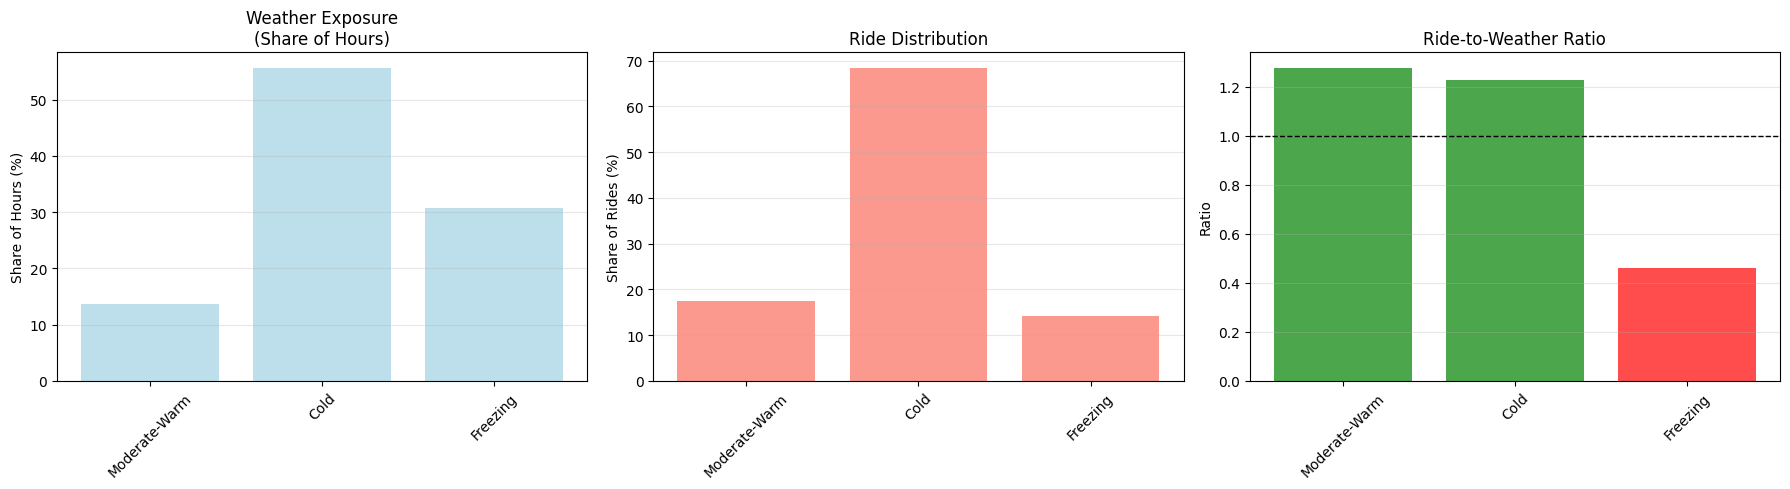

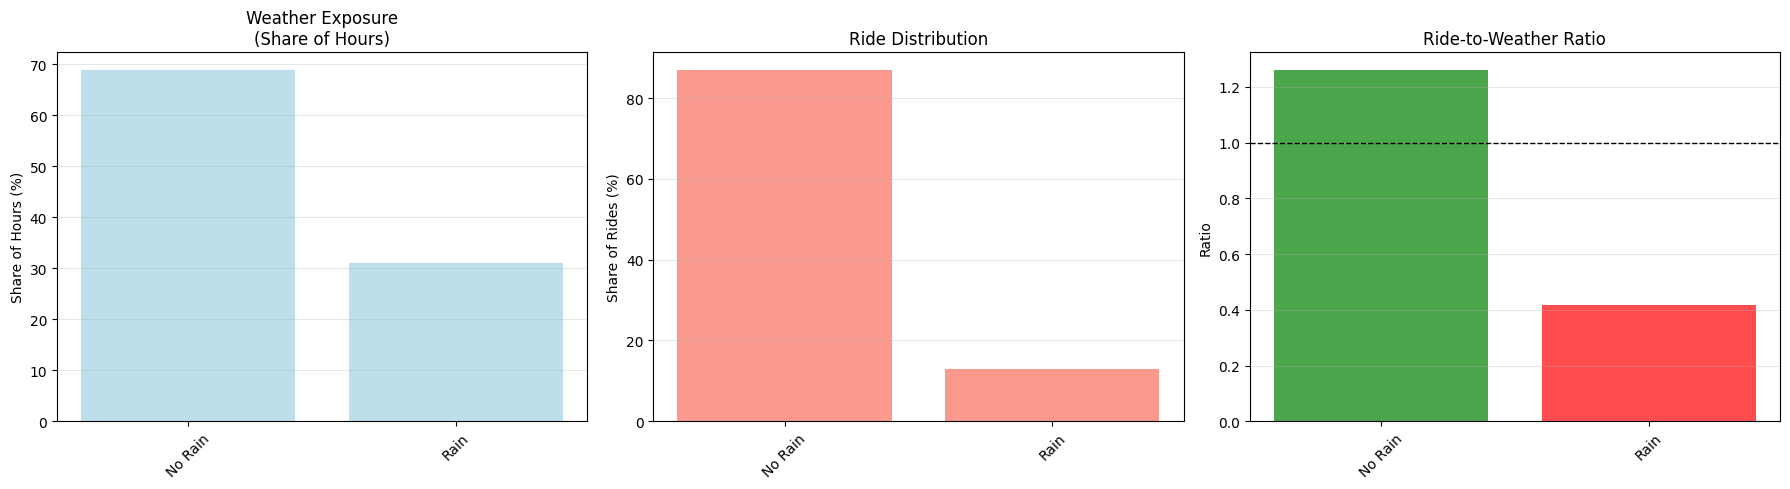

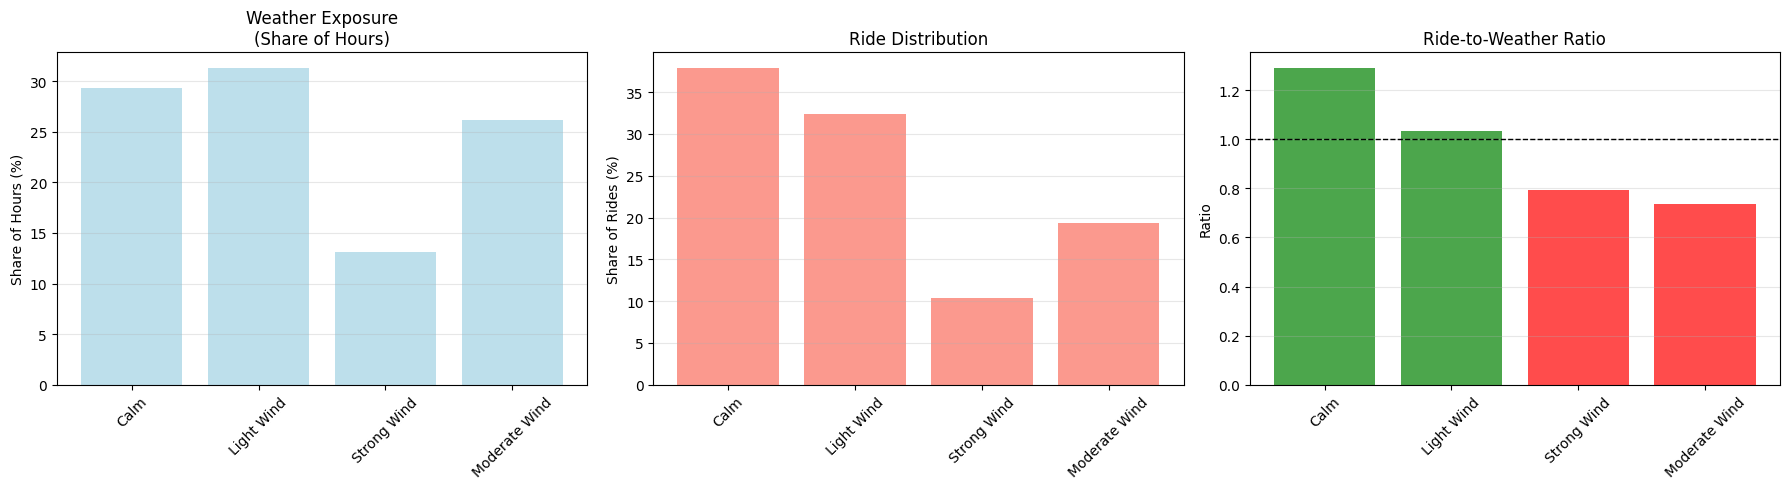

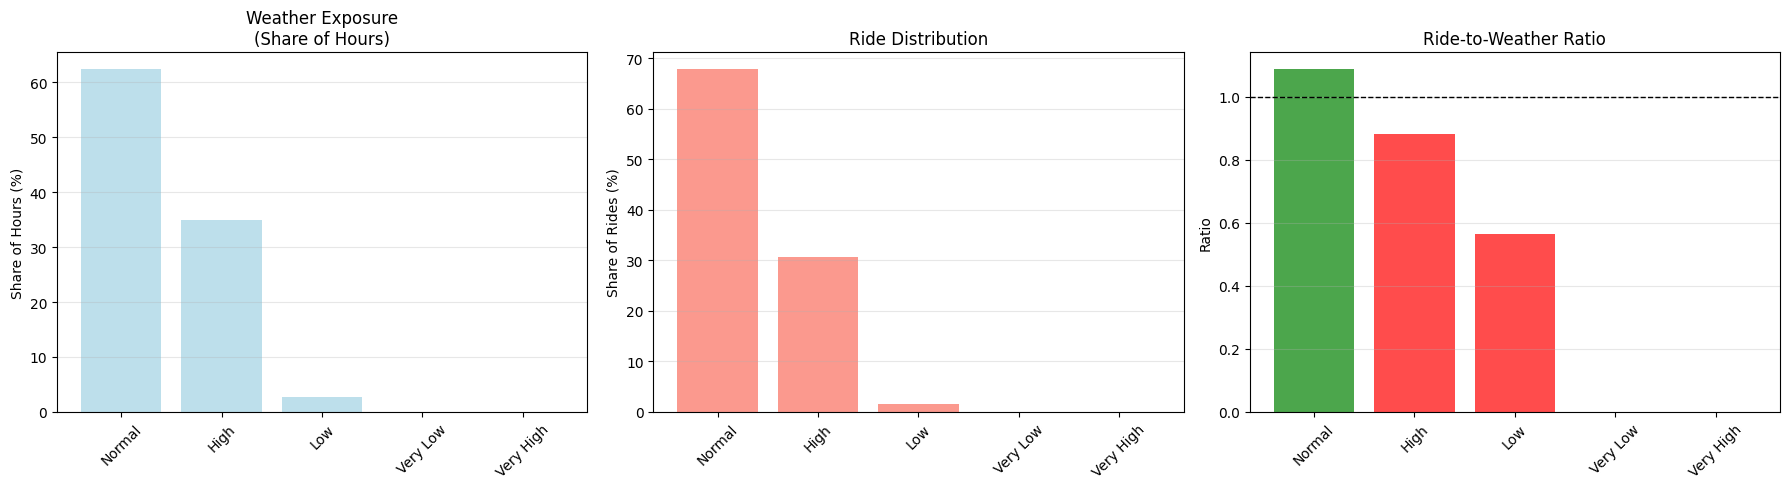

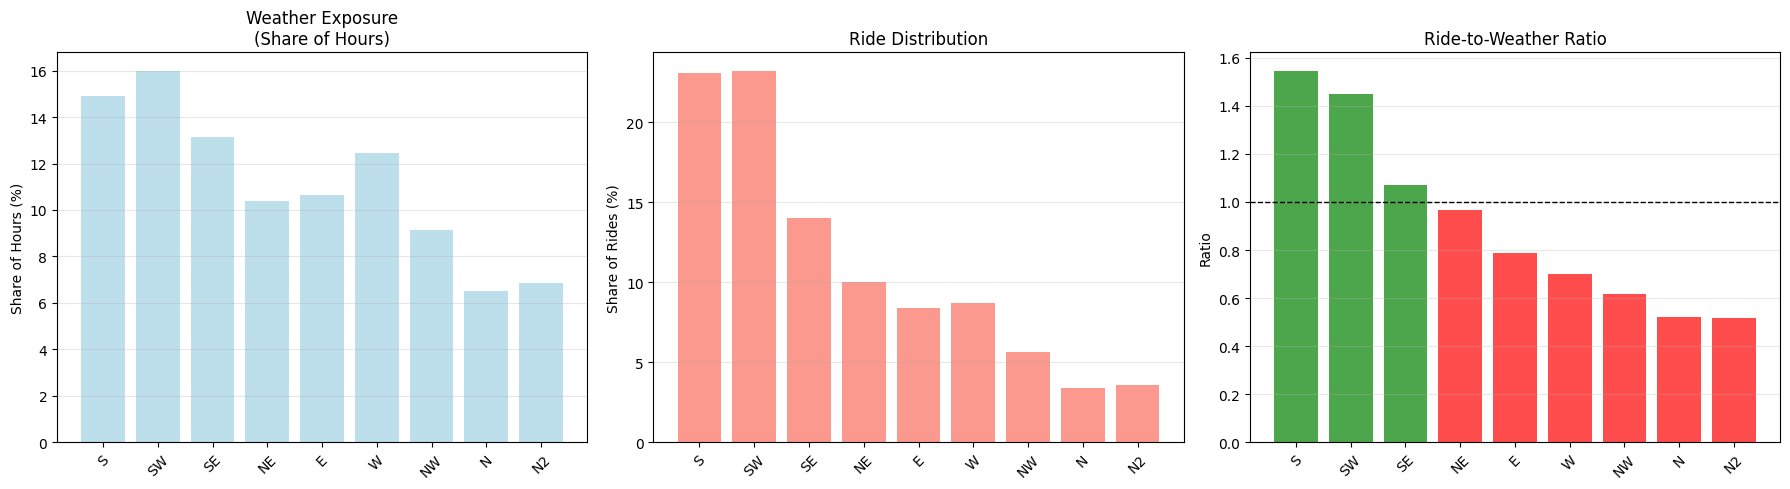

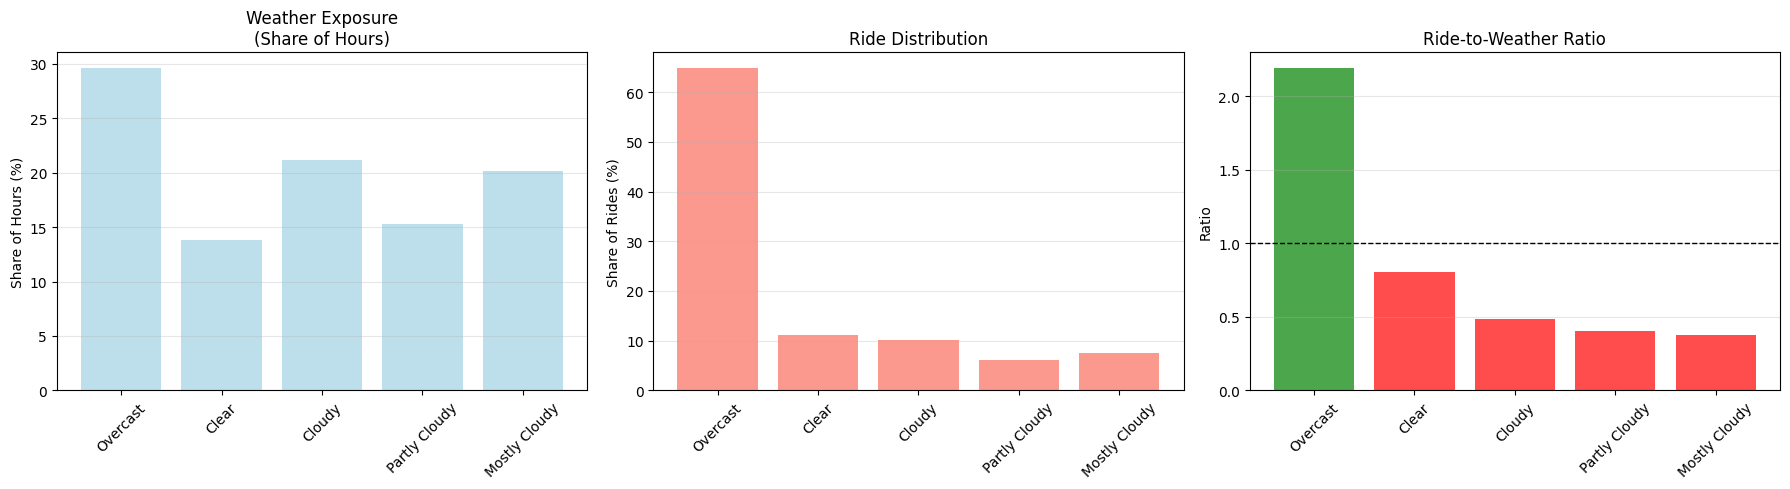

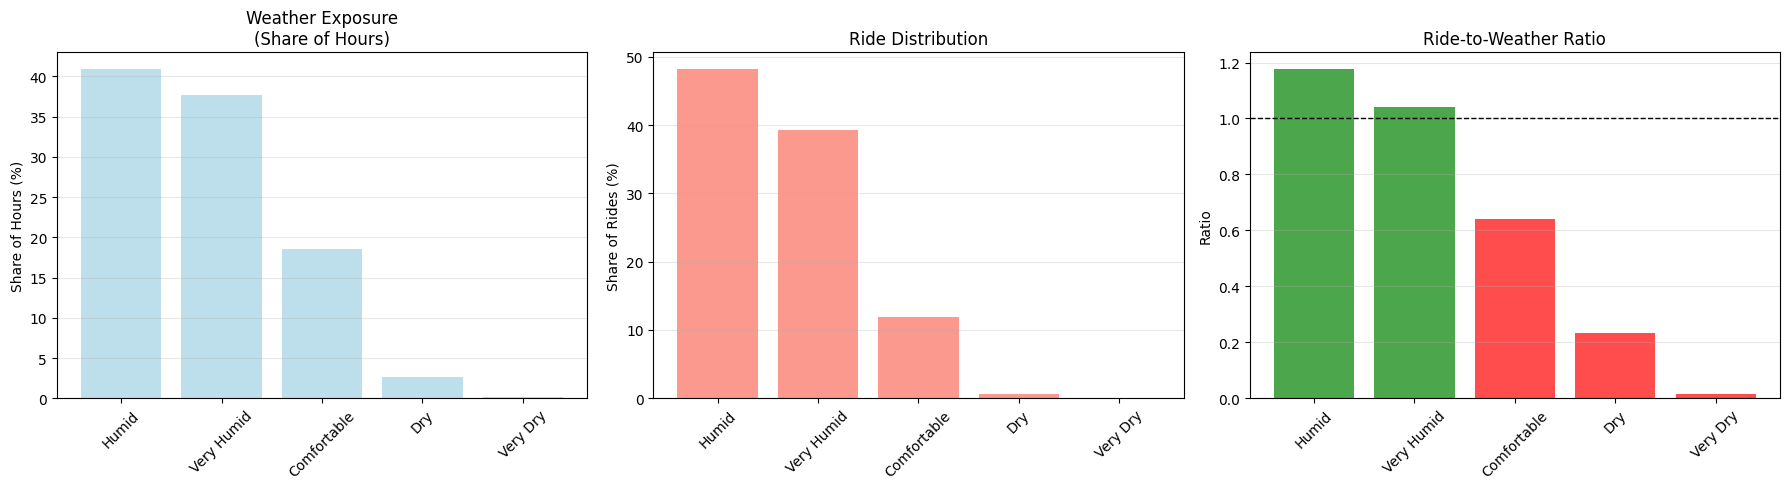

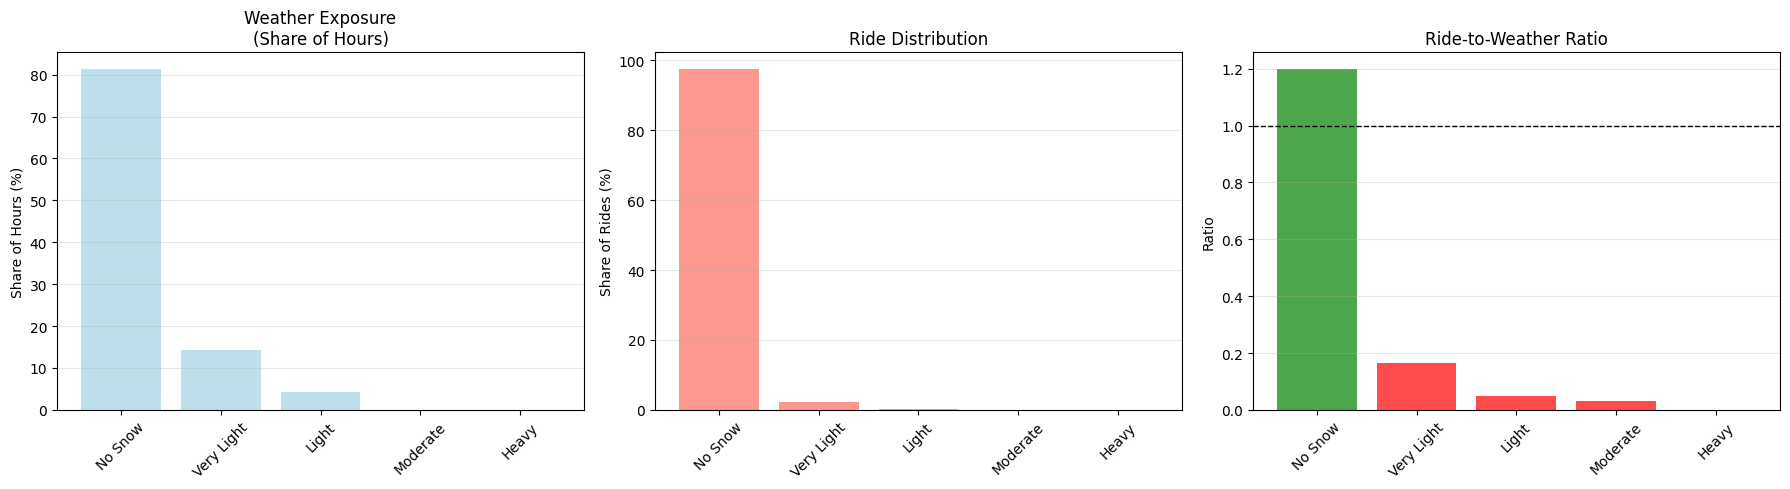

In [19]:
#this gives a bit more interesting perspective on how people use scooters in different weathers,
#accounting for the fact that the distributions are heavily skewed
for i in ['temp_category', 'rain_category', 'wind_category',
       'pressure_category', 'winddirection_category', 'cloudcover_category',
       'humidity_category', 'snowfall_category']:
    plot_weather_hourly_ratio(df_weather, i)

hour: 0


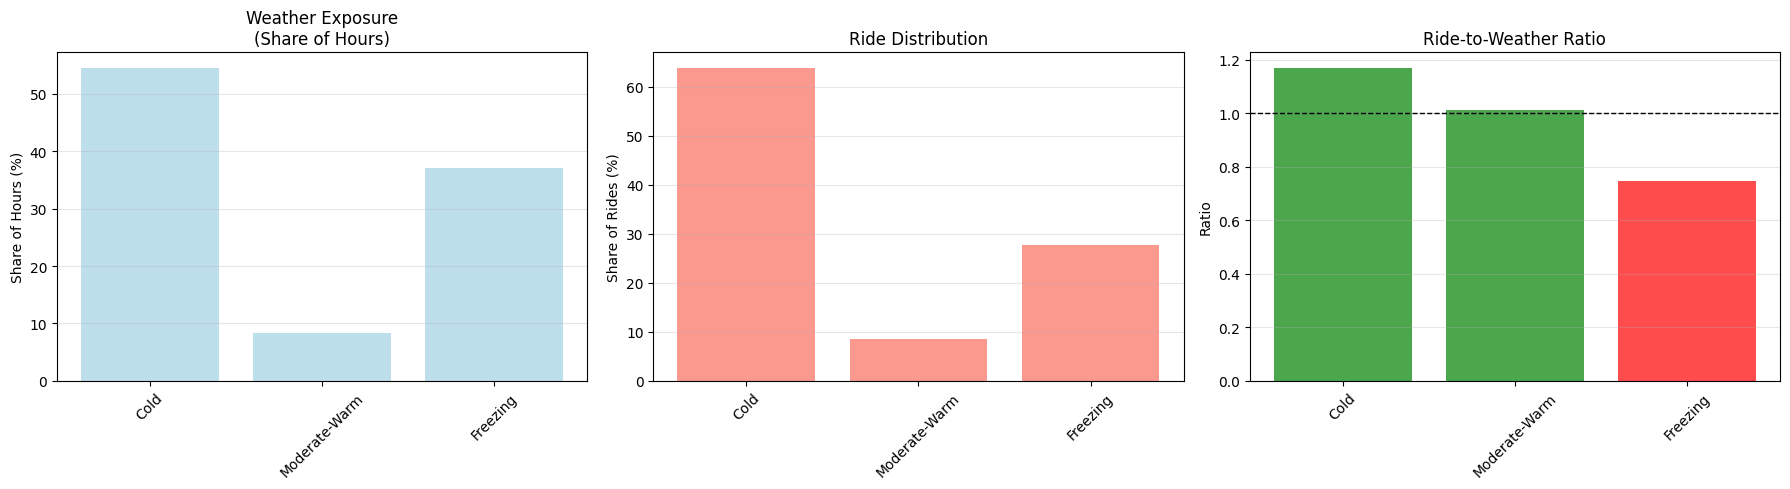

hour: 1


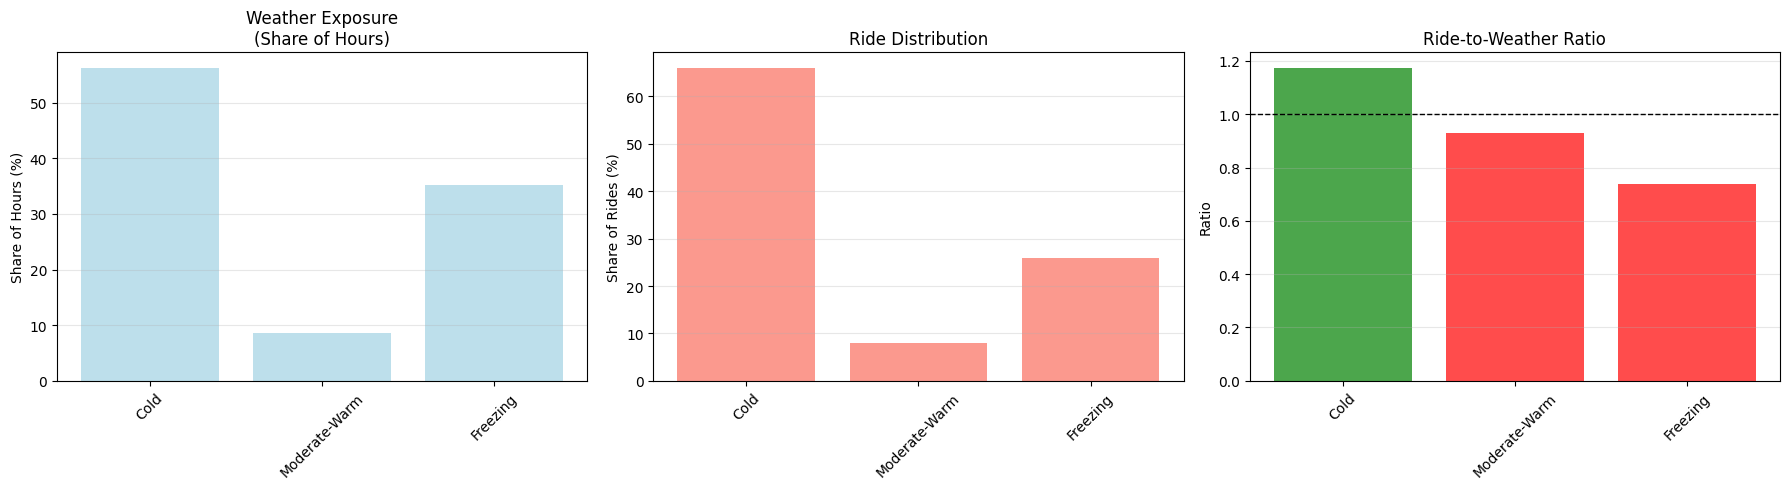

hour: 2


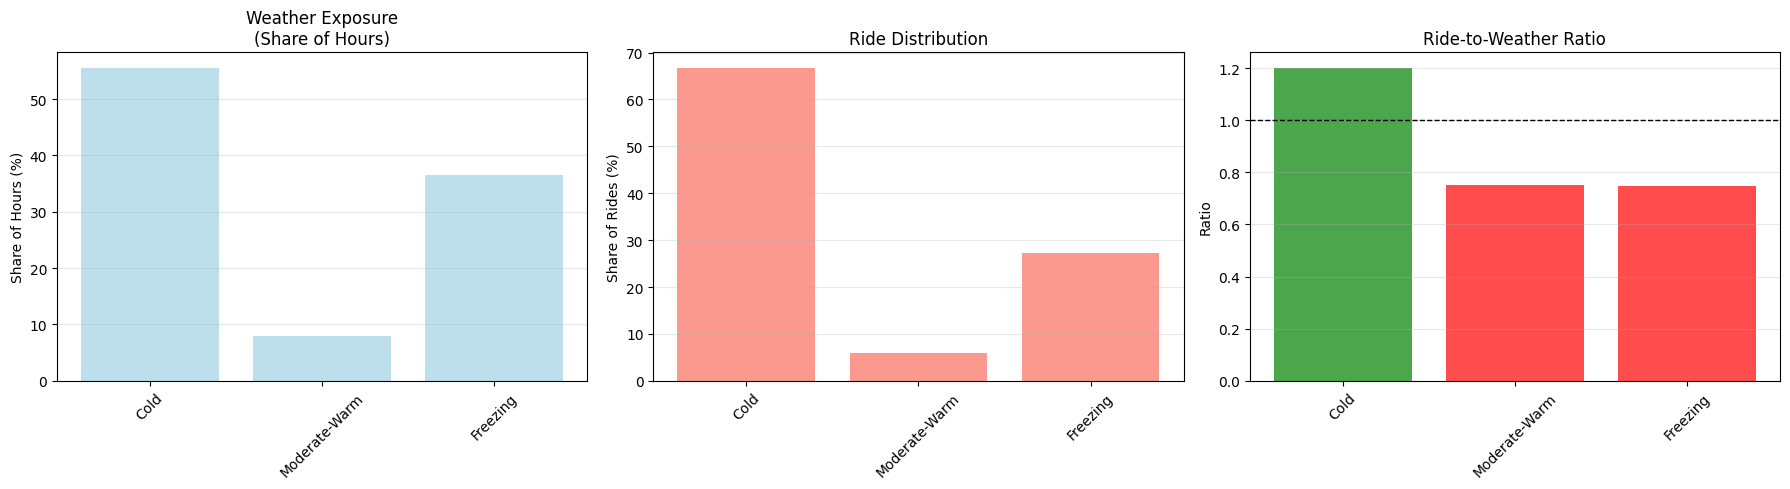

hour: 3


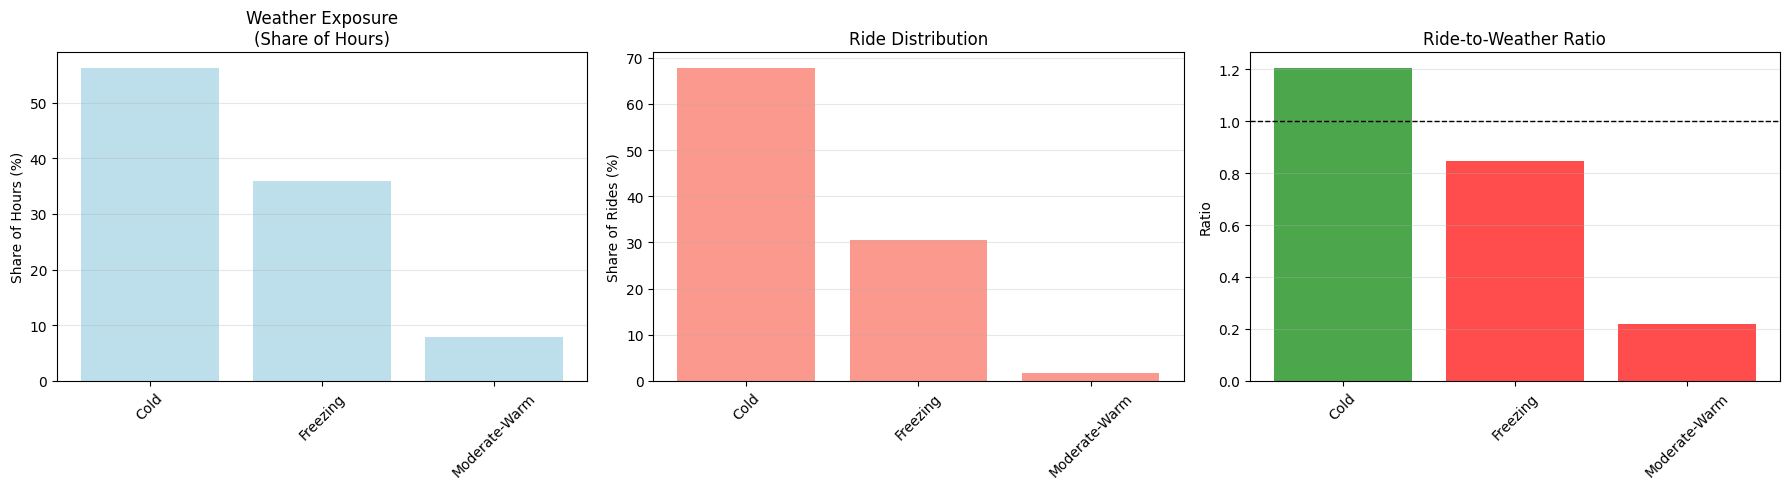

hour: 4


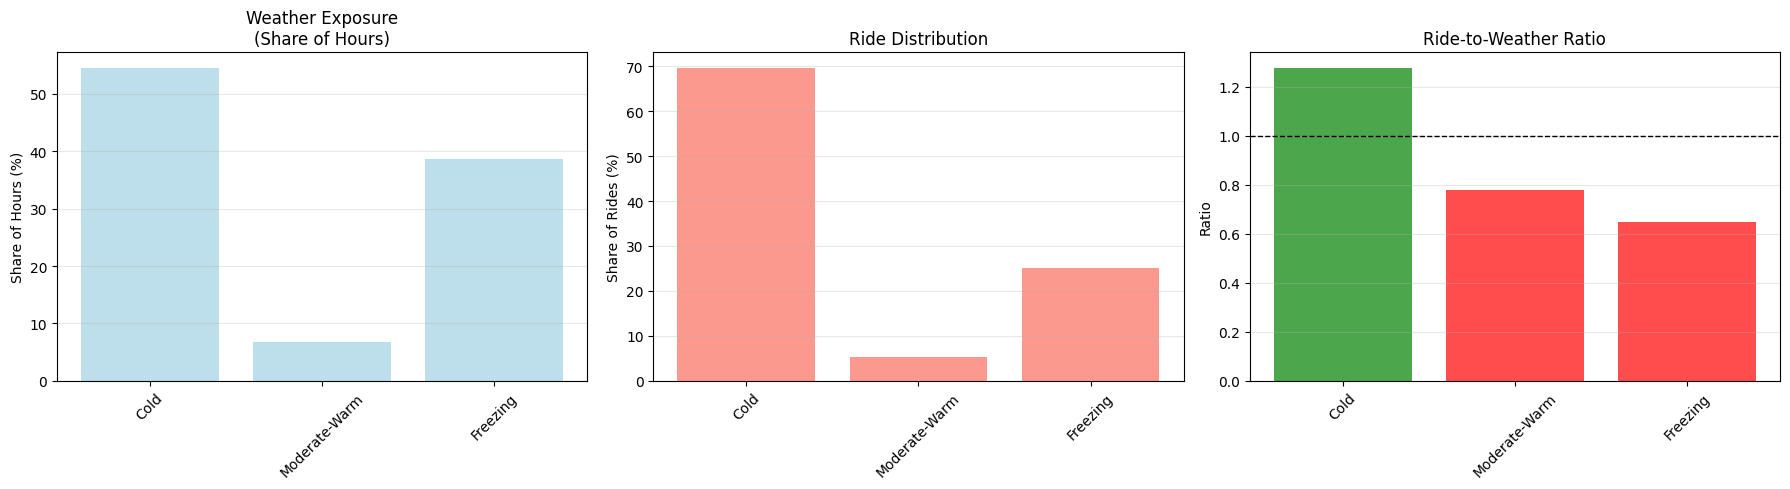

hour: 5


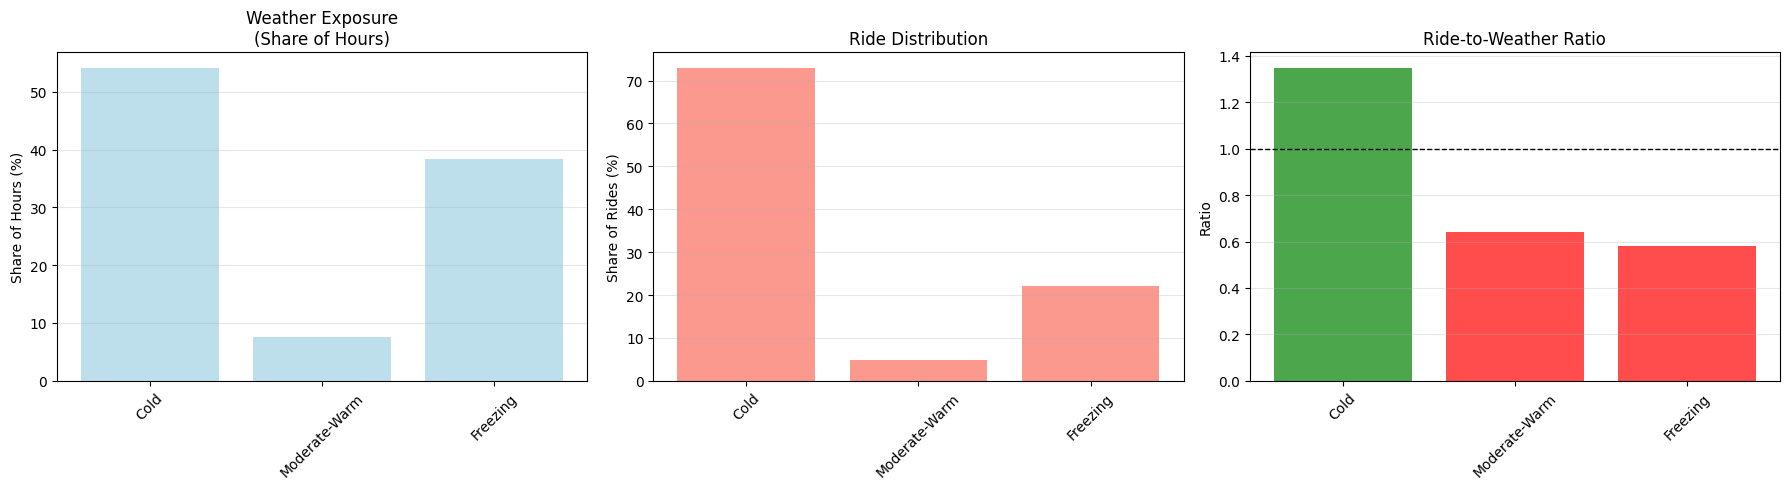

hour: 6


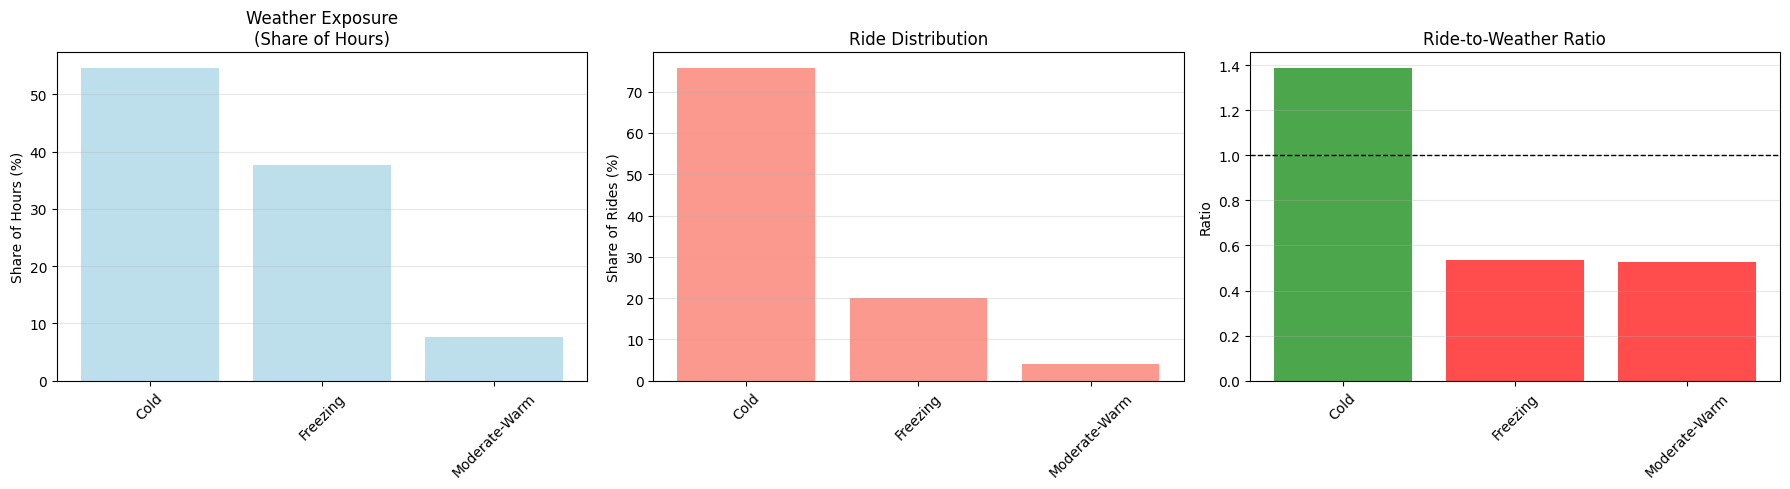

hour: 7


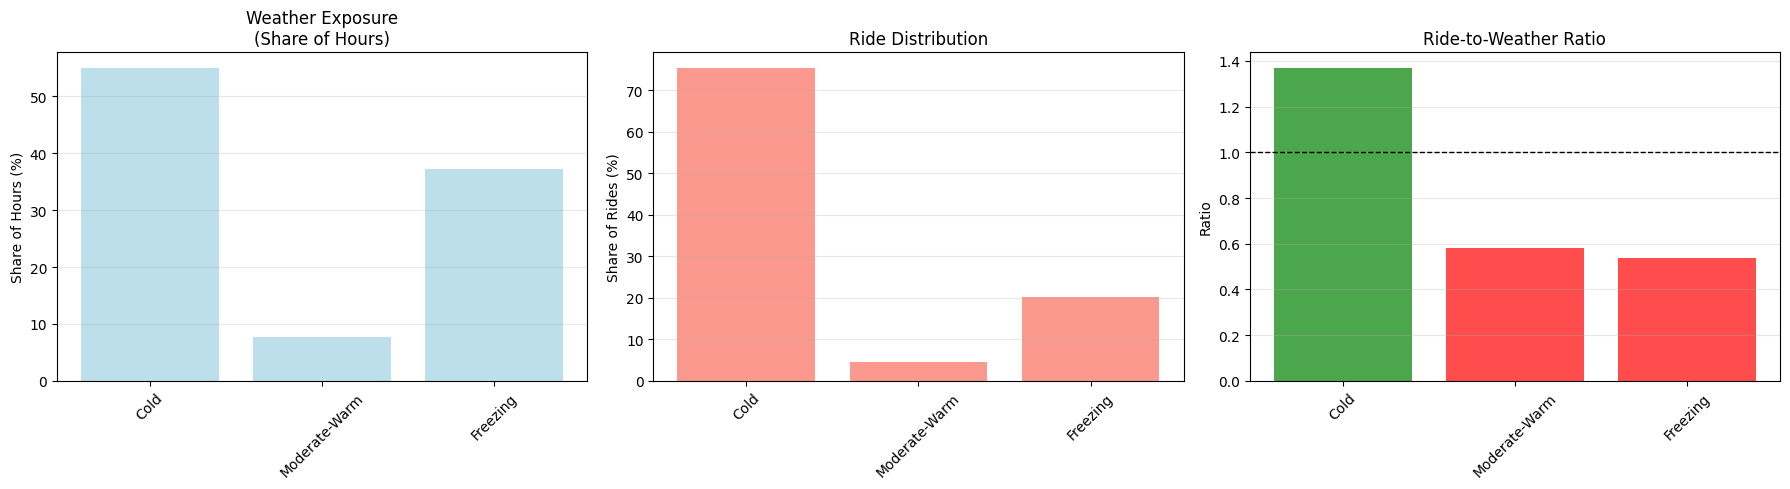

hour: 8


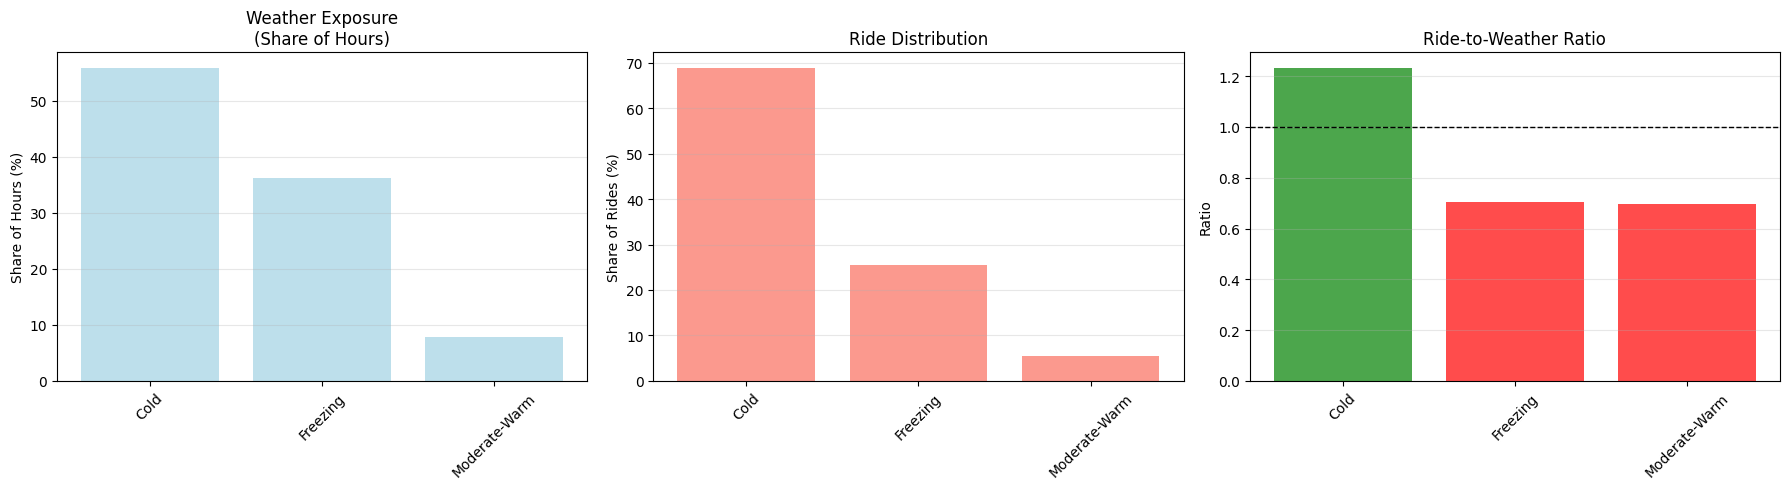

hour: 9


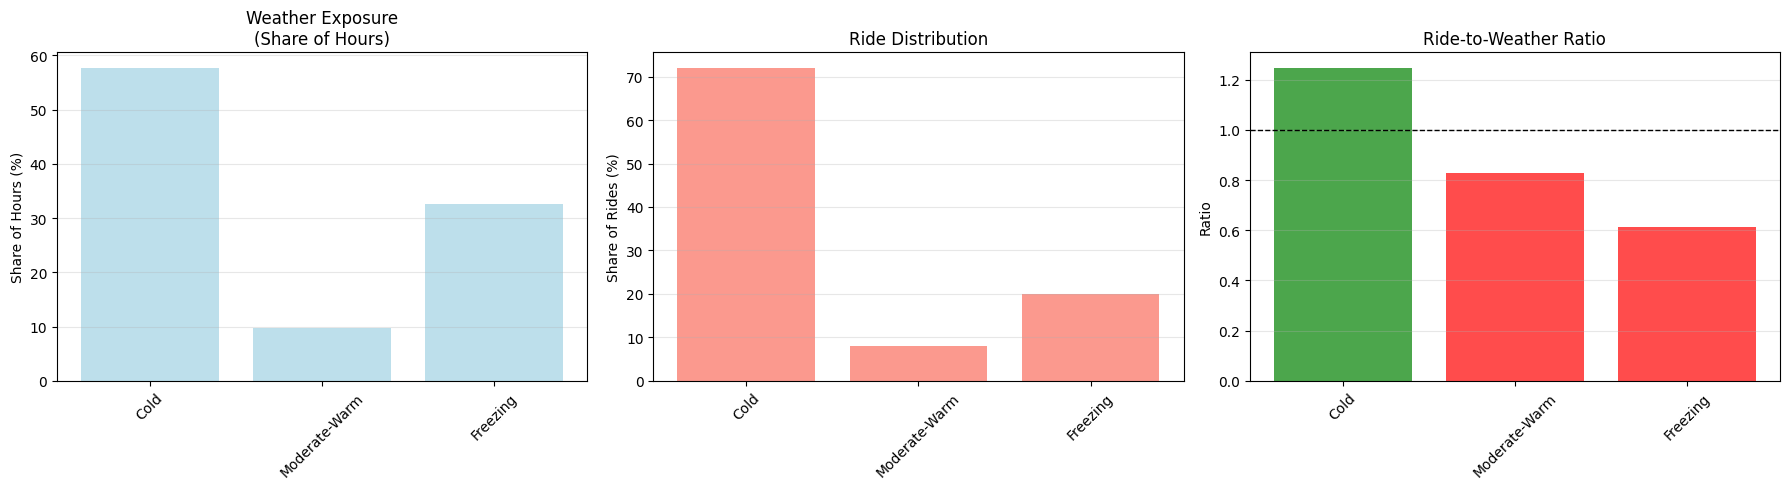

hour: 10


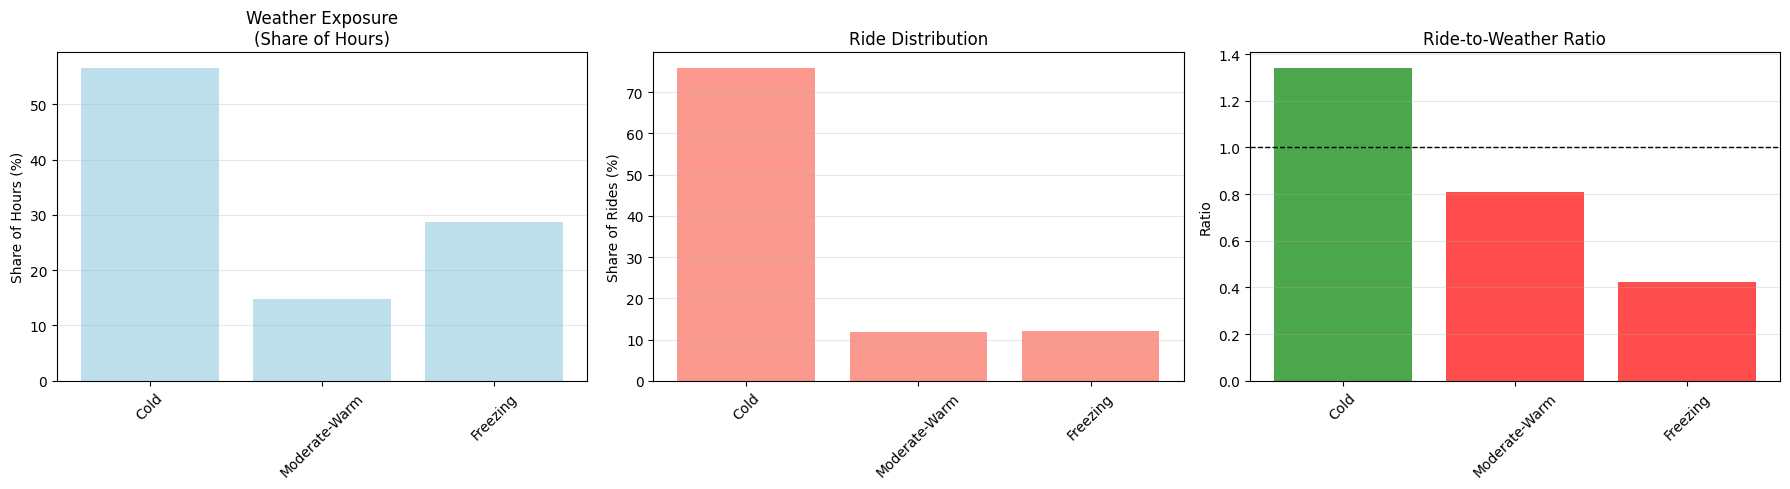

hour: 11


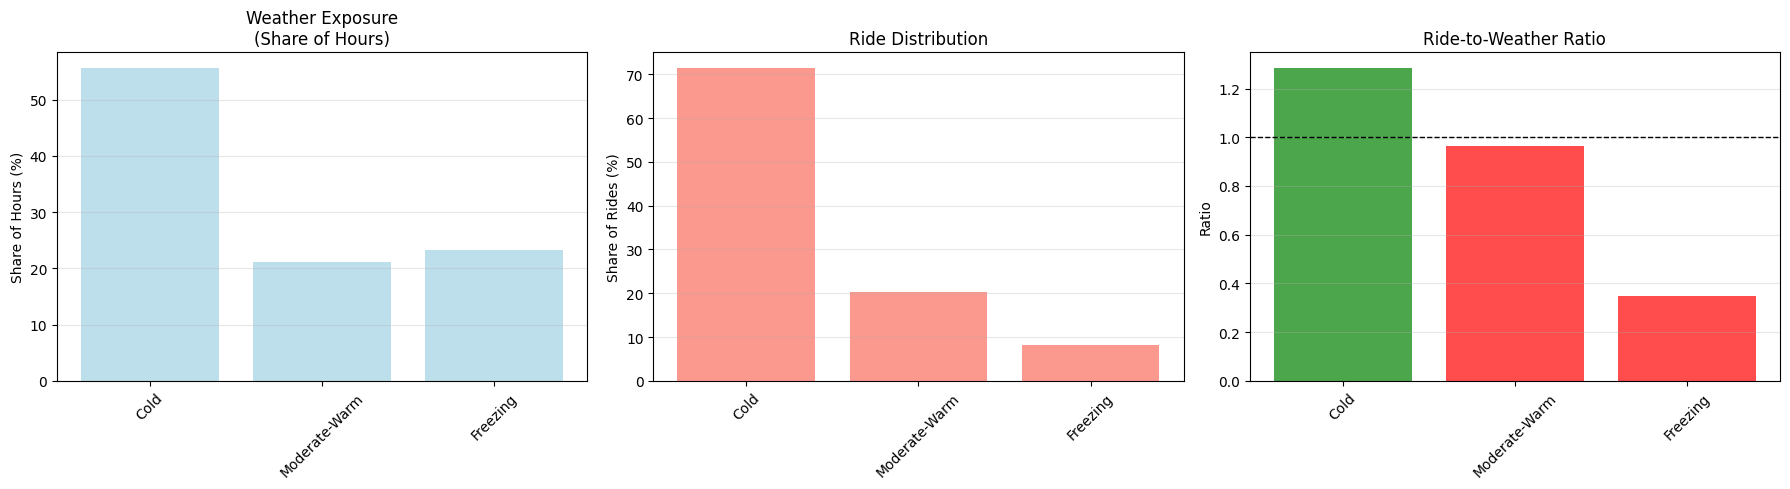

hour: 12


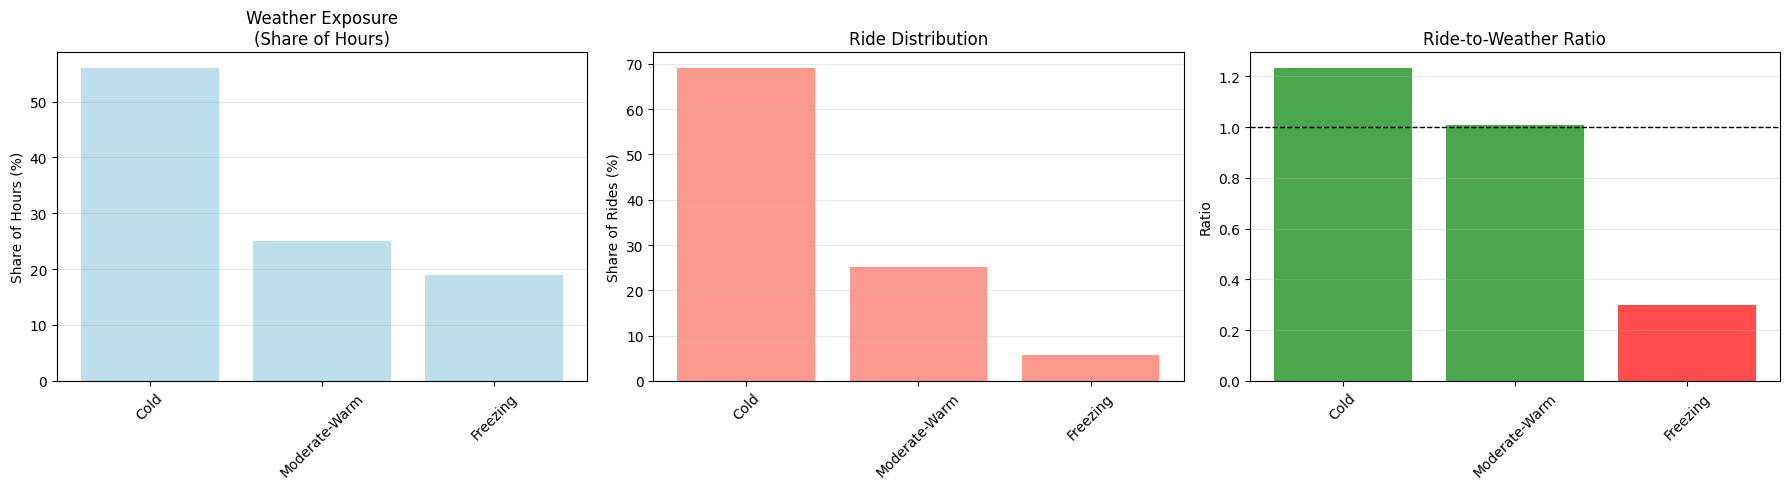

hour: 13


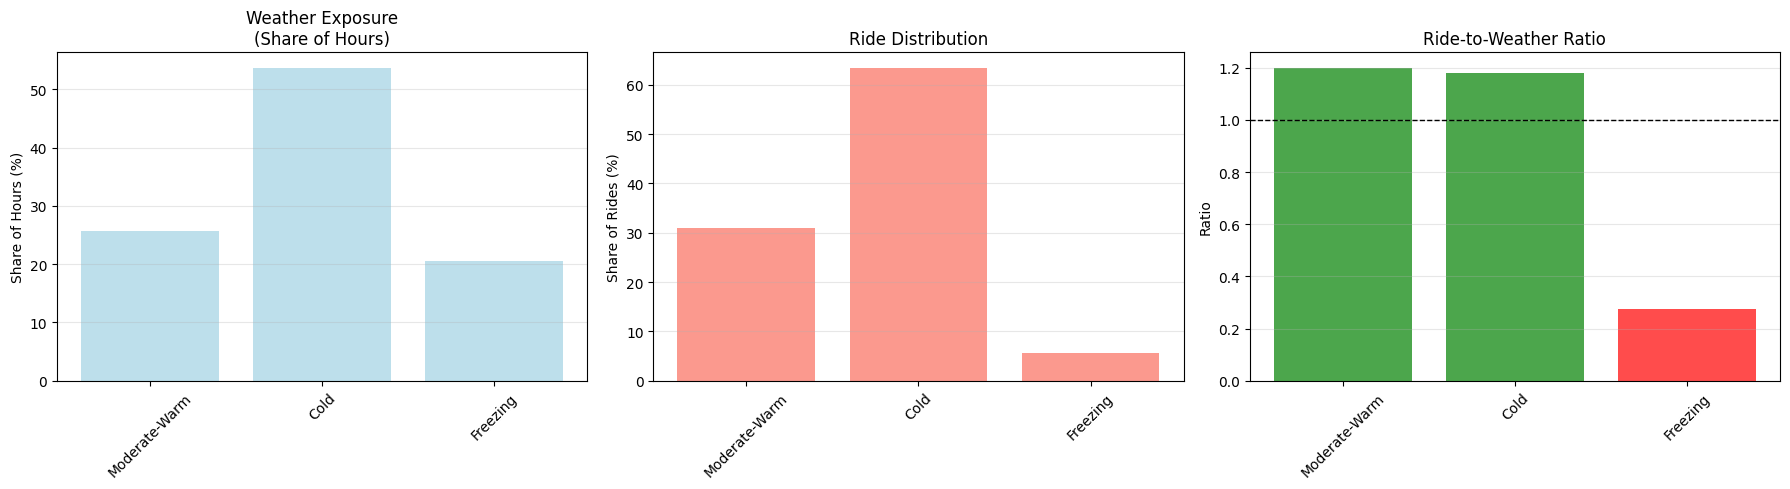

hour: 14


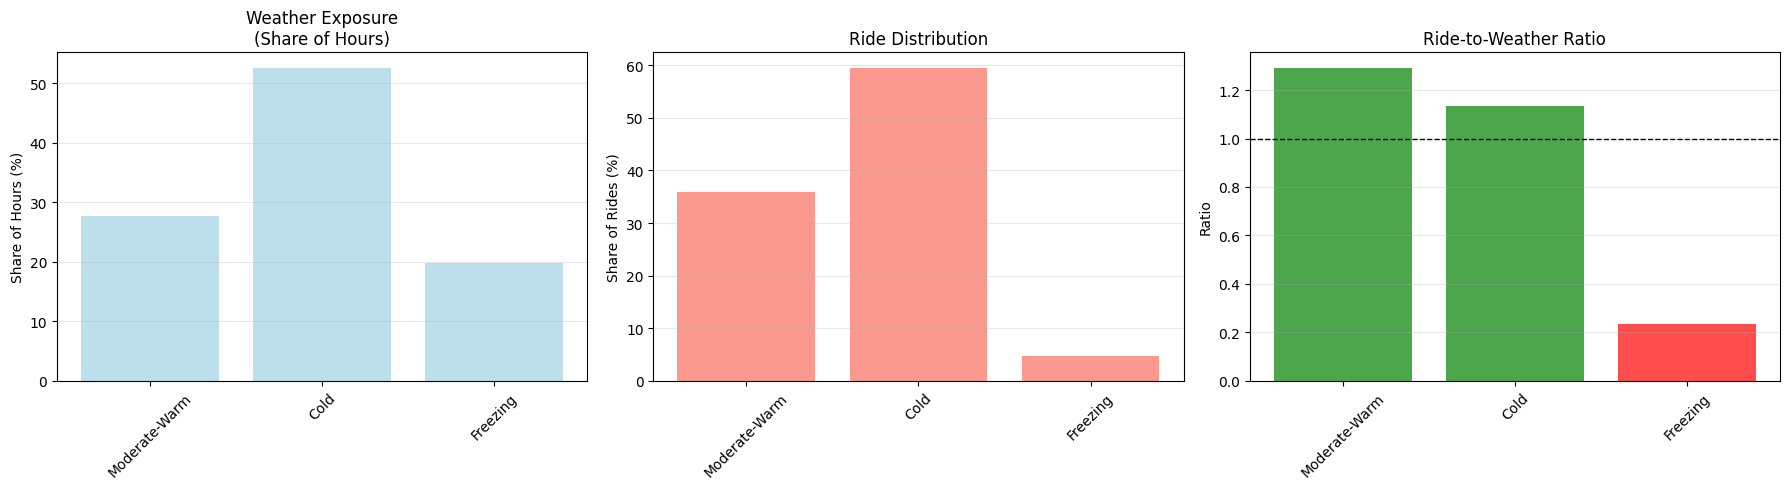

hour: 15


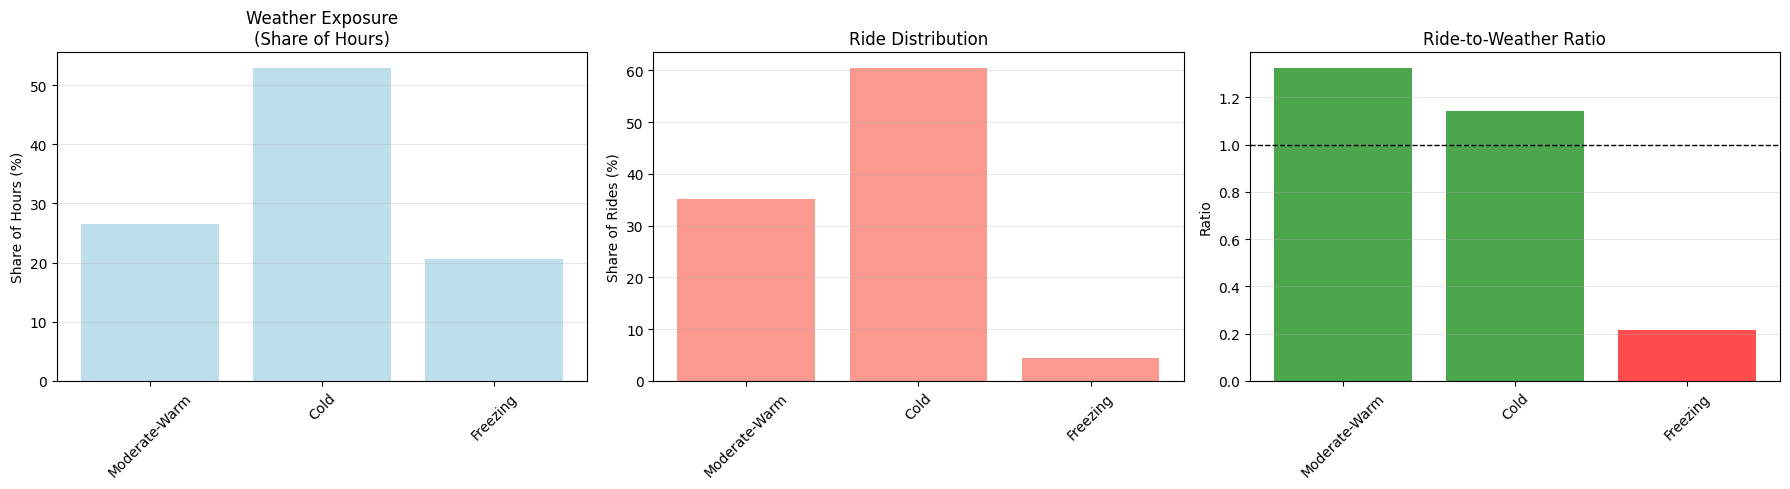

hour: 16


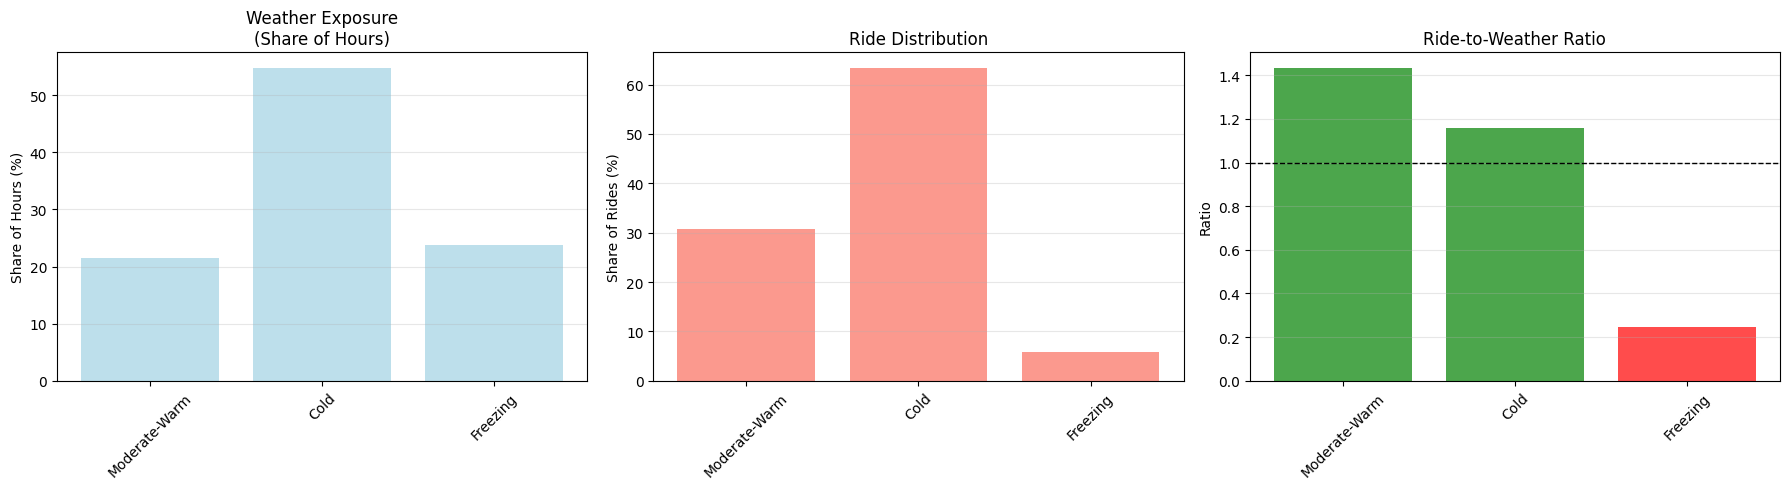

hour: 17


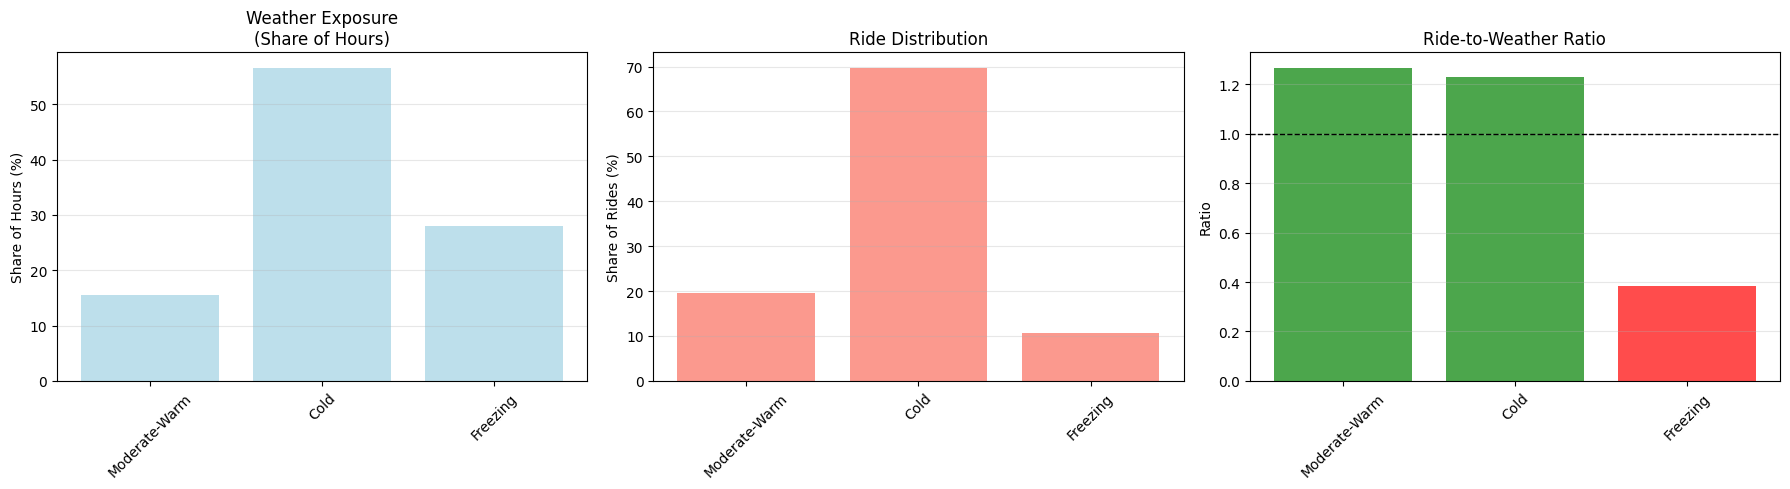

hour: 18


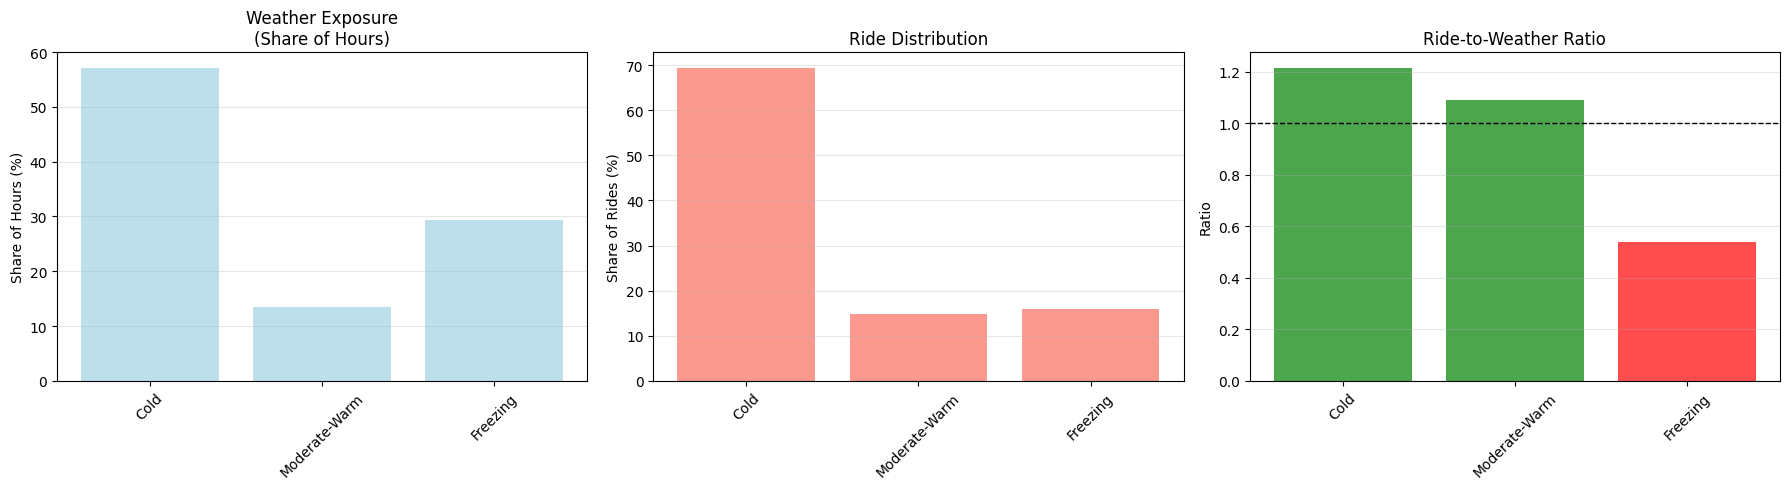

hour: 19


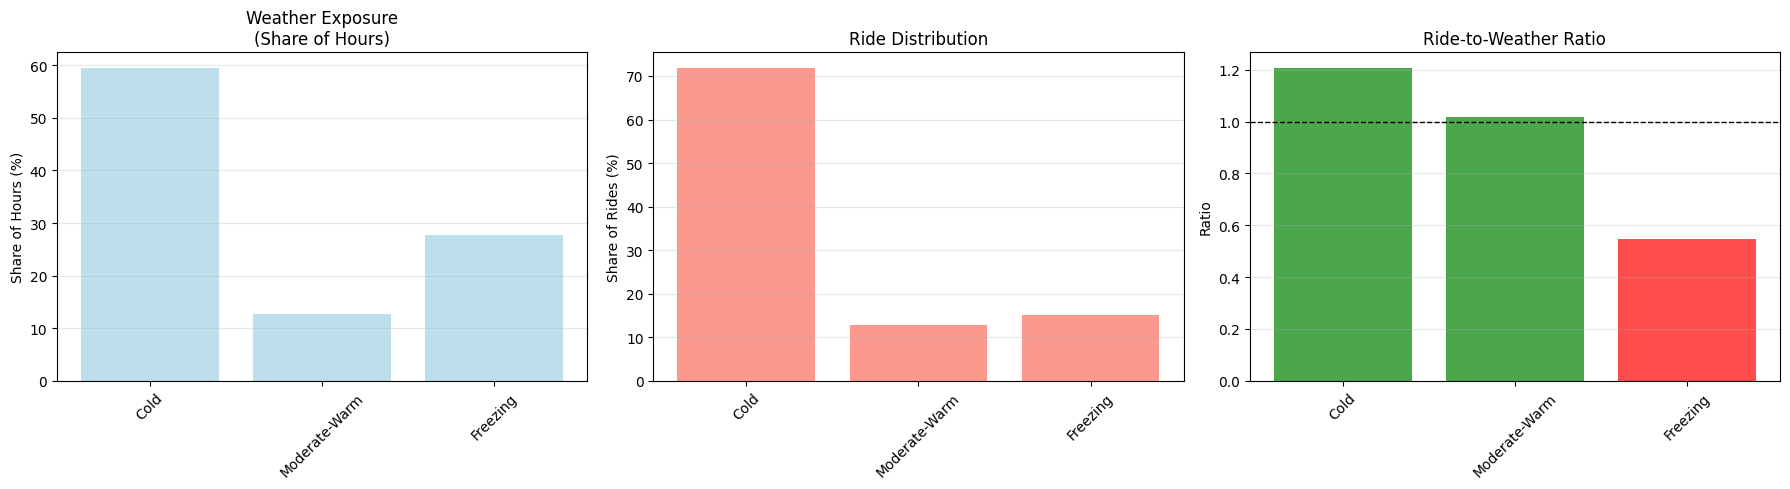

hour: 20


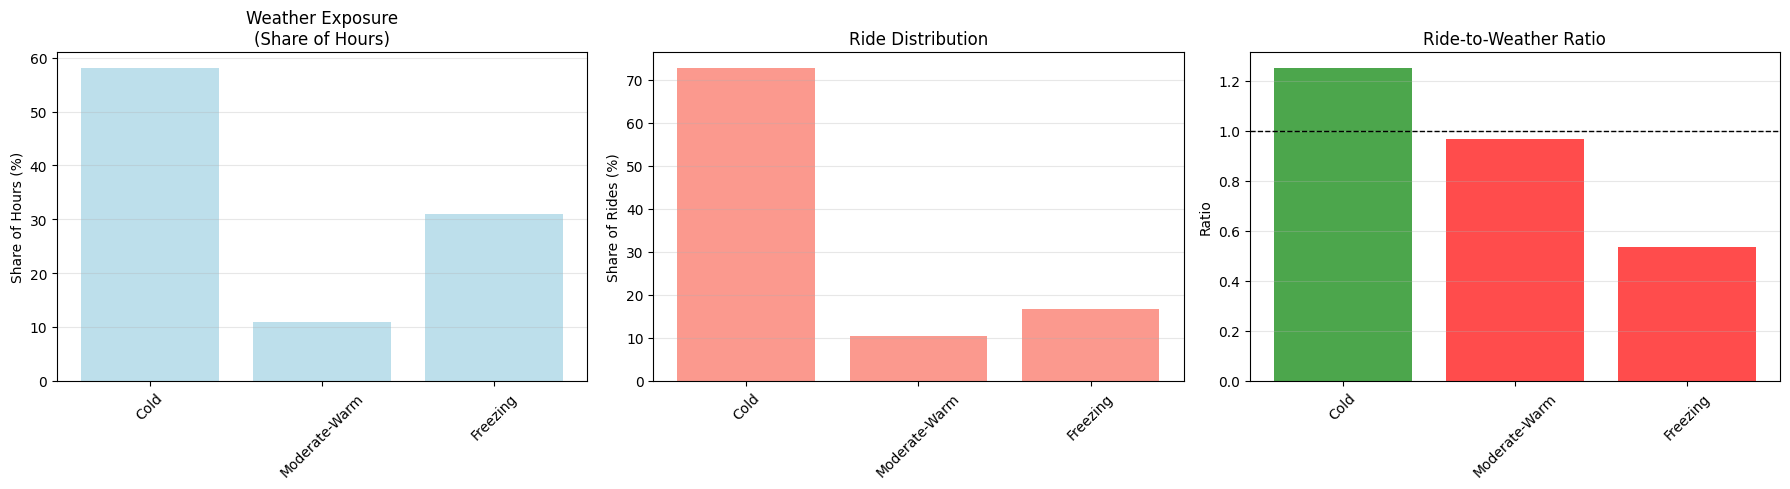

hour: 21


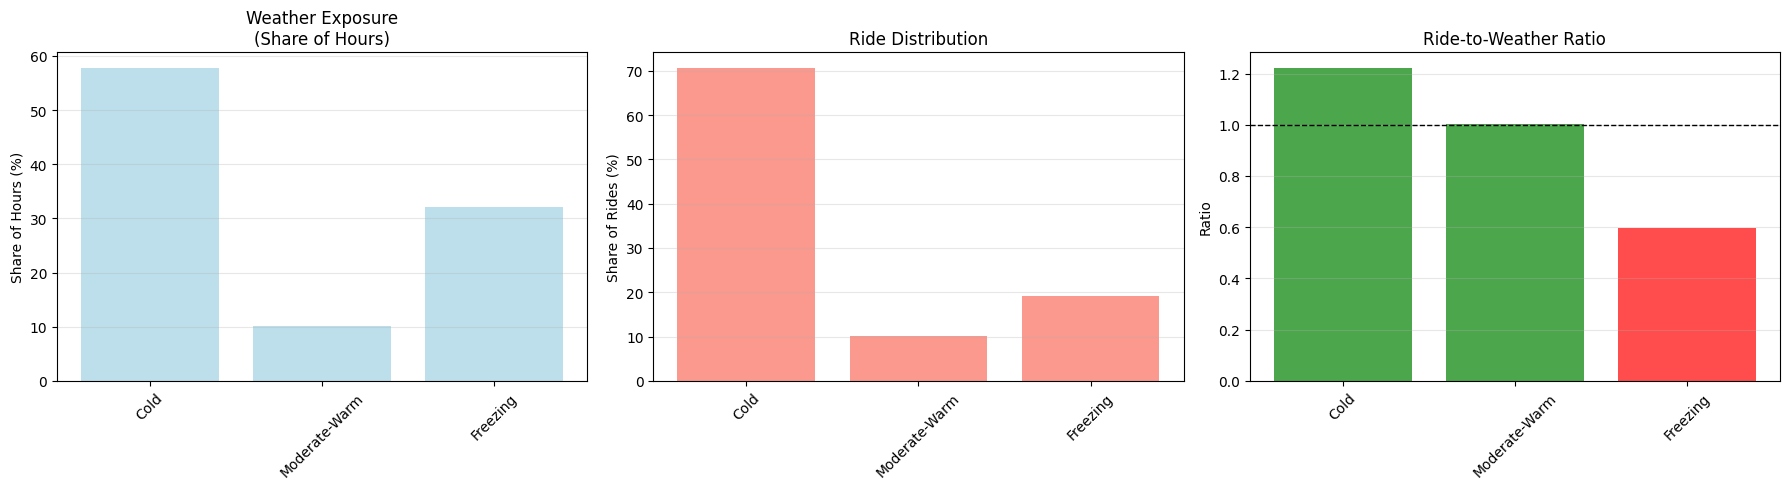

hour: 22


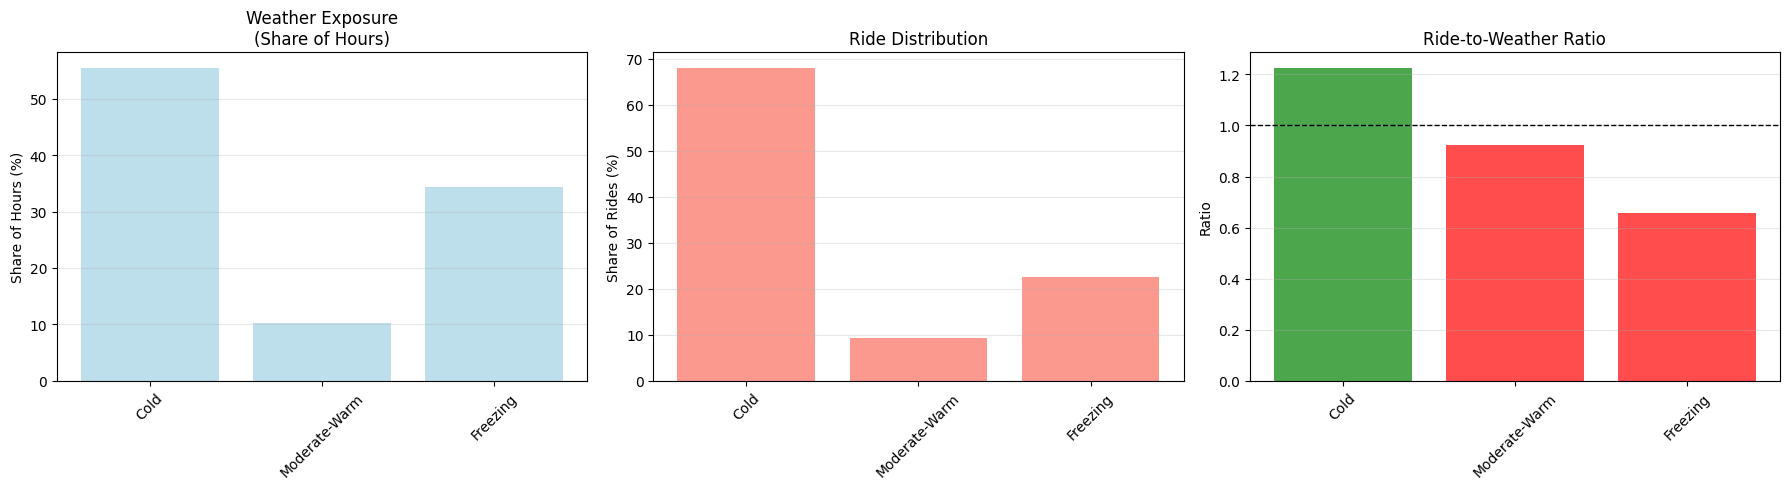

hour: 23


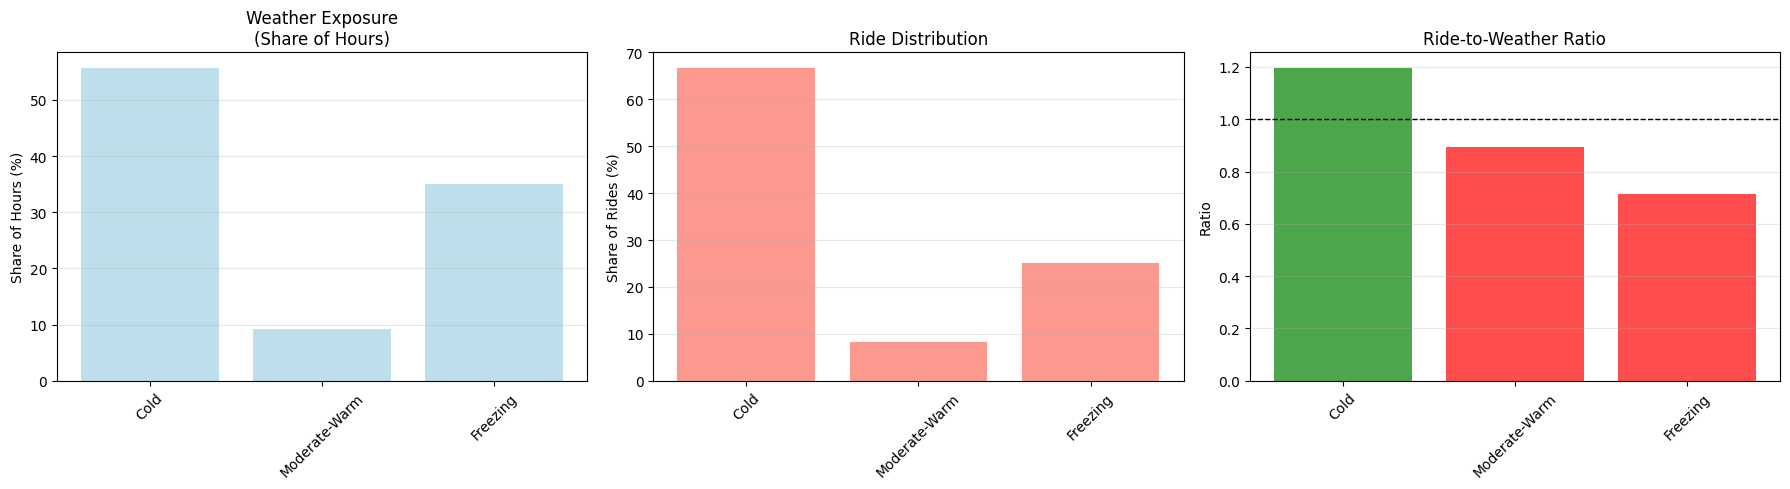

        Cold  Moderate-Warm  Freezing
0   1.170370       1.012140  0.746935
1   1.174095       0.928252  0.738986
2   1.201447       0.752098  0.747342
3   1.205943       0.219279  0.847376
4   1.276852       0.777716  0.648376
5   1.348312       0.639231  0.579005
6   1.387669       0.527402  0.534724
7   1.370246       0.581743  0.539481
8   1.233242       0.695188  0.706260
9   1.247781       0.827039  0.612077
10  1.341411       0.811192  0.423360
11  1.285216       0.965686  0.350154
12  1.233638       1.008397  0.297348
13  1.181831       1.200039  0.275892
14  1.132433       1.291988  0.235900
15  1.142305       1.325248  0.215897
16  1.156641       1.433965  0.244487
17  1.231699       1.267425  0.382718
18  1.214776       1.088534  0.540600
19  1.207559       1.016002  0.547915
20  1.252536       0.968909  0.537377
21  1.222532       1.003465  0.597258
22  1.225851       0.923068  0.658289
23  1.196972       0.892948  0.715340


In [20]:
#now let's get rid of temporal effects (at night it is generally cold + no one uses scooters)
hours = sorted(df_weather['hour'].unique())
categories = df_weather['temp_category'].unique()

ratio_table = pd.DataFrame(index=hours, columns=categories)

for h in hours:
    print("hour:", h)
    df_hour = df_weather[df_weather['hour'] == h]
    comparison = plot_weather_hourly_ratio(df_hour, 'temp_category')  # or just return the comparison DataFrame
    ratio_table.loc[h, comparison.index] = comparison['ratio'].values

ratio_table = ratio_table.astype(float)
print(ratio_table)

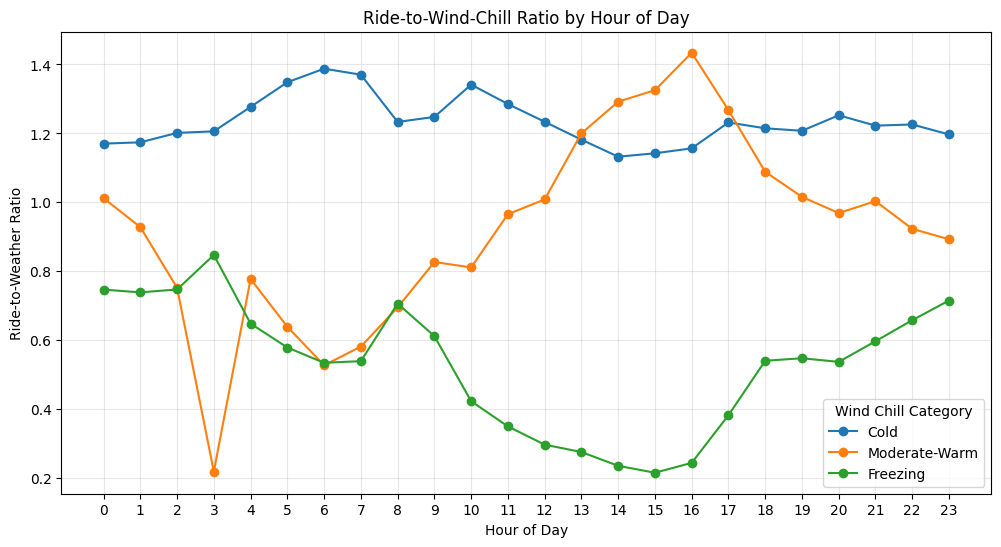

In [21]:
plt.figure(figsize=(12,6))

for cat in categories:
    plt.plot(ratio_table.index, ratio_table[cat], marker='o', label=cat)

plt.xlabel("Hour of Day")
plt.ylabel("Ride-to-Weather Ratio")
plt.title("Ride-to-Wind-Chill Ratio by Hour of Day")
plt.grid(True, alpha=0.3)
plt.legend(title="Wind Chill Category")
plt.xticks(hours)
plt.show()

#actually quite interesting, because freezing category obviously is not the best option,
#while moderate and cold are quite popular. there are still obvious effects of skewed dataset, 
#so we cannot do meaningful eda with weather data, much more interesting would be to build a model with it

In [22]:

def plot_daily_rides_vs_weather(
    df,
    date_col,
    rides_col,
    weather_col,
    window=7,
    title_raw="Daily Scooter Usage and Weather Over Time",
    title_smooth="Smoothed Daily Scooter Usage and Weather"
):

    daily = df.copy()
    daily[date_col] = pd.to_datetime(daily[date_col])
    daily = daily.sort_values(date_col).set_index(date_col)

   #1
    fig, ax1 = plt.subplots(figsize=(14, 6))

    ax1.plot(
        daily.index,
        daily[rides_col],
        color='tab:blue',
        label='Number of rides'
    )
    ax1.set_ylabel("Number of rides", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.plot(
        daily.index,
        daily[weather_col],
        color='tab:red',
        label='Weather metric'
    )
    ax2.set_ylabel(weather_col, color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title(title_raw)
    fig.autofmt_xdate()
    plt.show()

  #2
    daily['rides_smooth'] = daily[rides_col].rolling(window).mean()
    daily['weather_smooth'] = daily[weather_col].rolling(window).mean()

    fig, ax1 = plt.subplots(figsize=(14, 6))

    ax1.plot(
        daily.index,
        daily['rides_smooth'],
        color='tab:blue',
        label=f'{window}-day avg rides'
    )
    ax1.set_ylabel("Number of rides", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.plot(
        daily.index,
        daily['weather_smooth'],
        color='tab:red',
        label=f'{window}-day avg weather'
    )
    ax2.set_ylabel(weather_col, color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title(title_smooth)
    fig.autofmt_xdate()
    plt.show()


City: Tuebingen


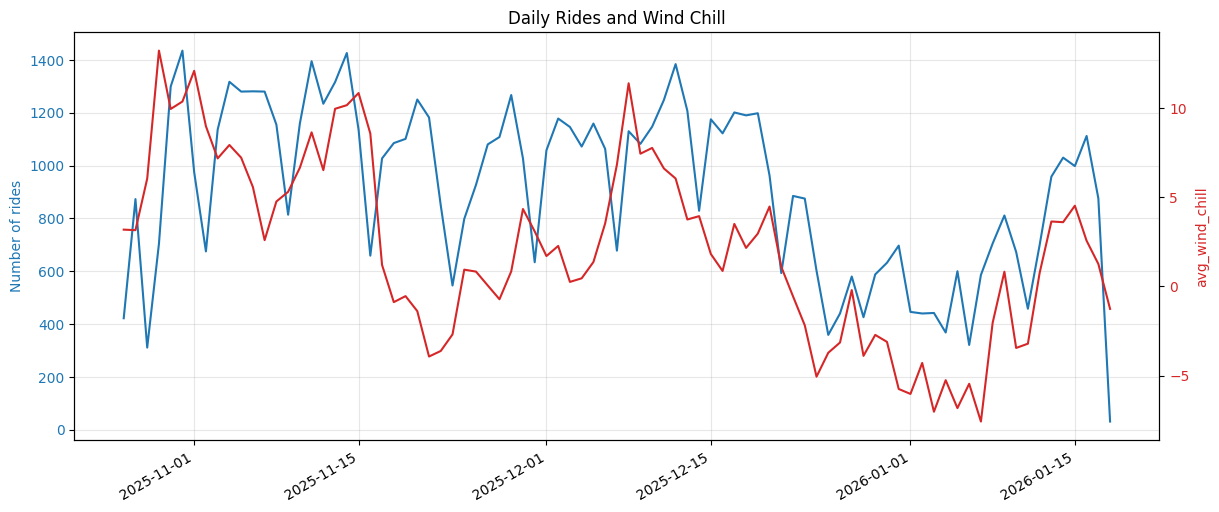

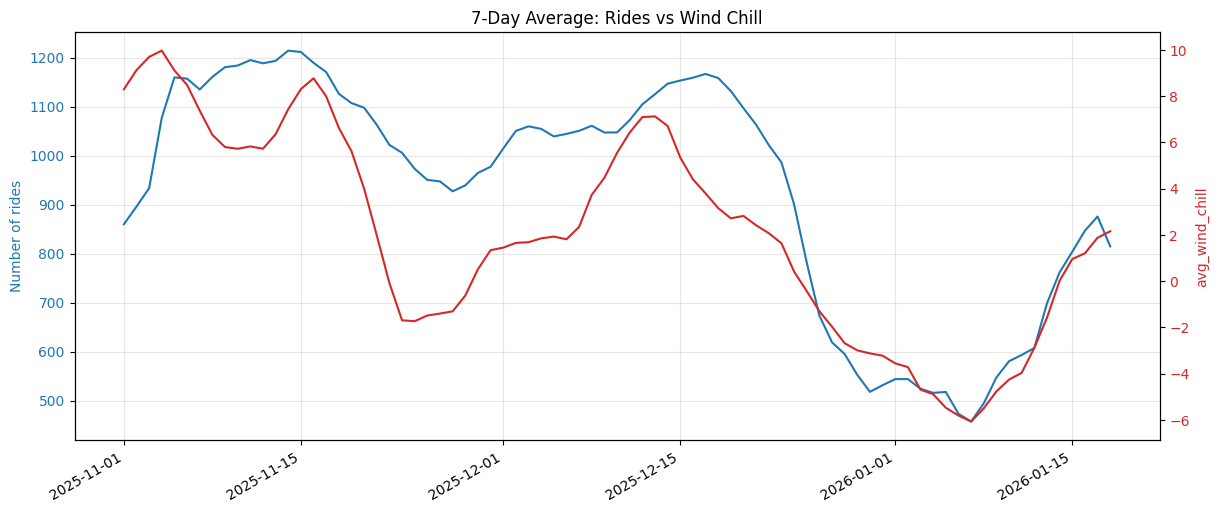

City: Heidelberg


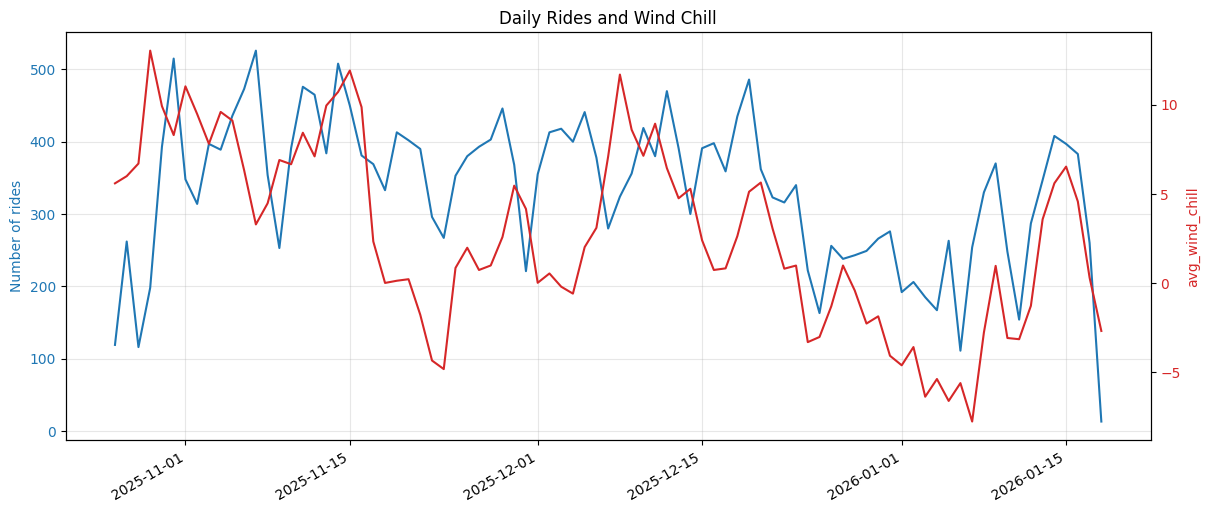

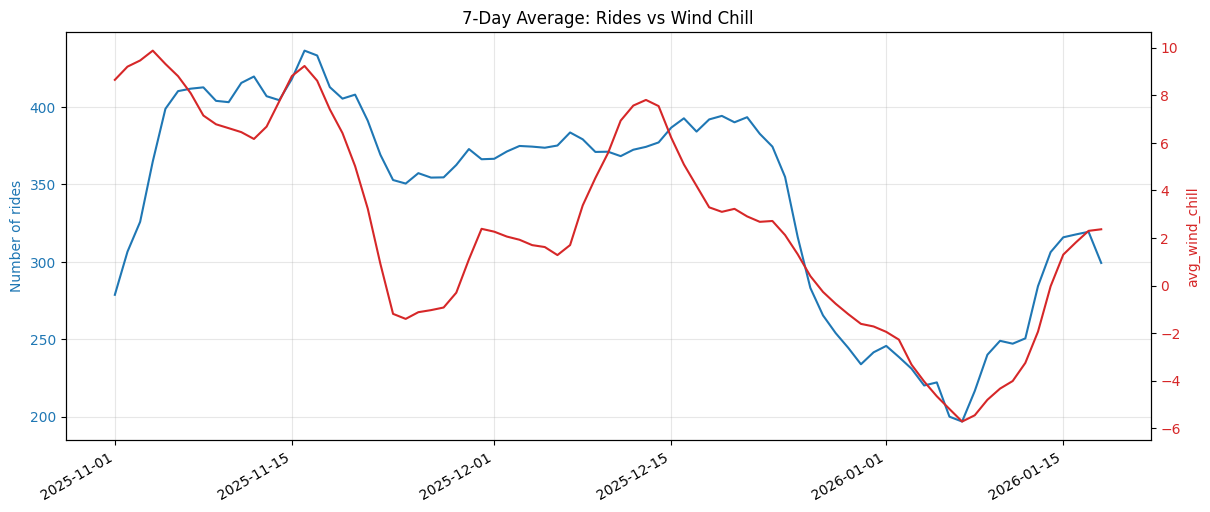

City: Reutlingen


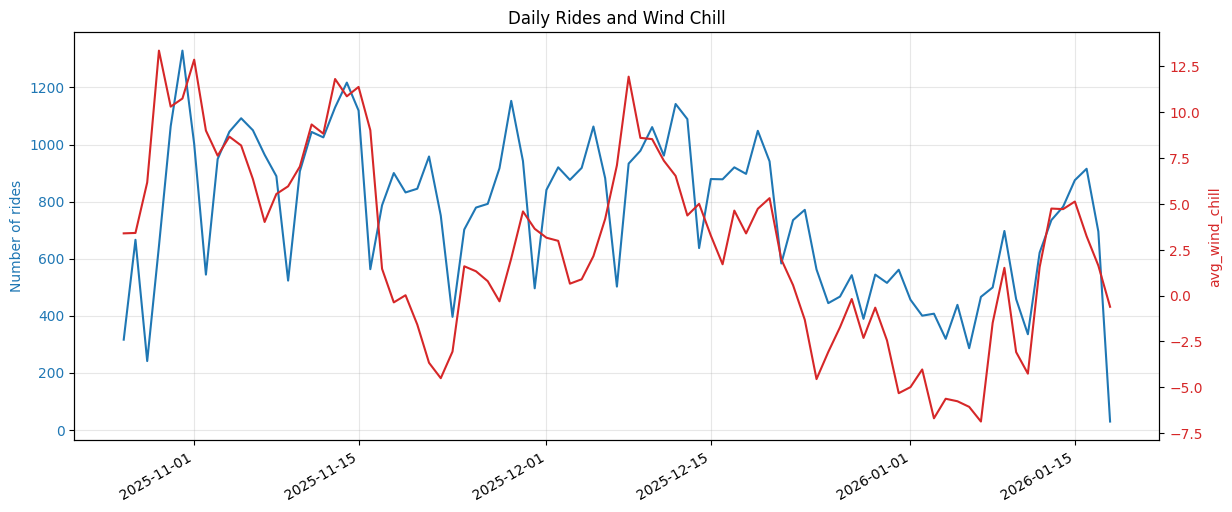

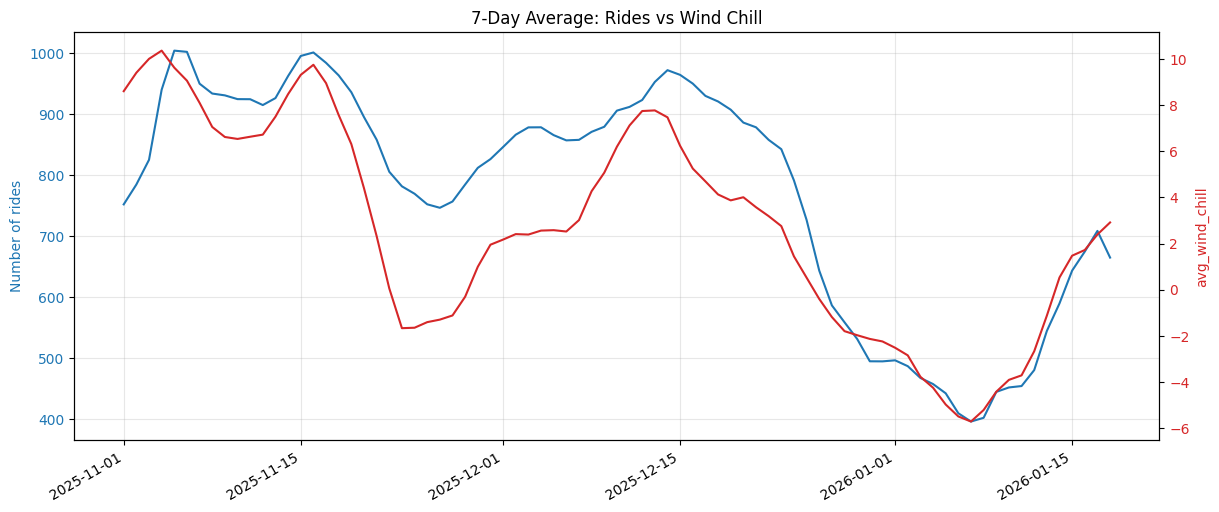

City: Stuttgart


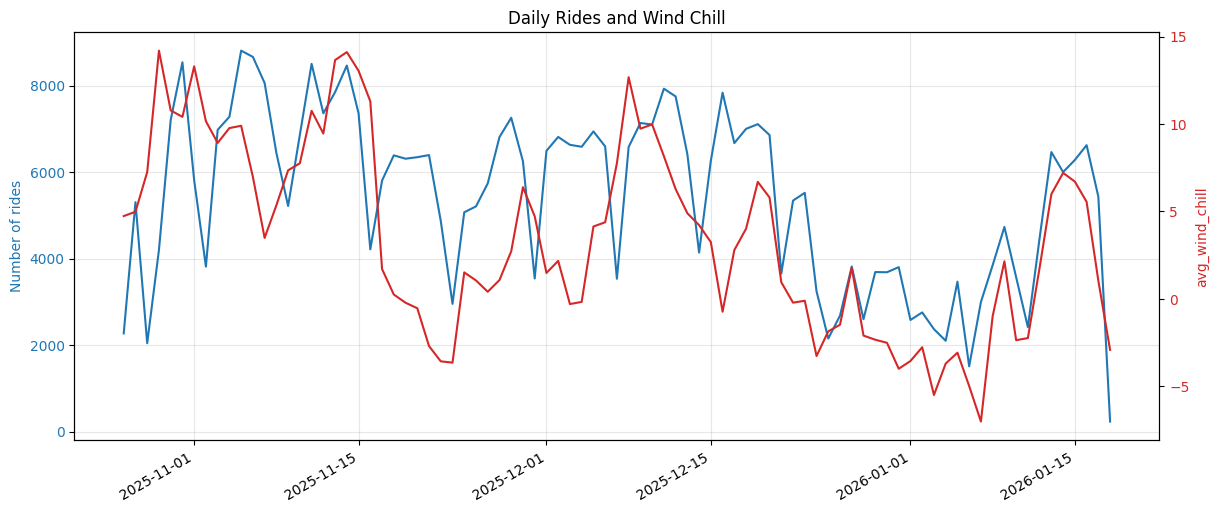

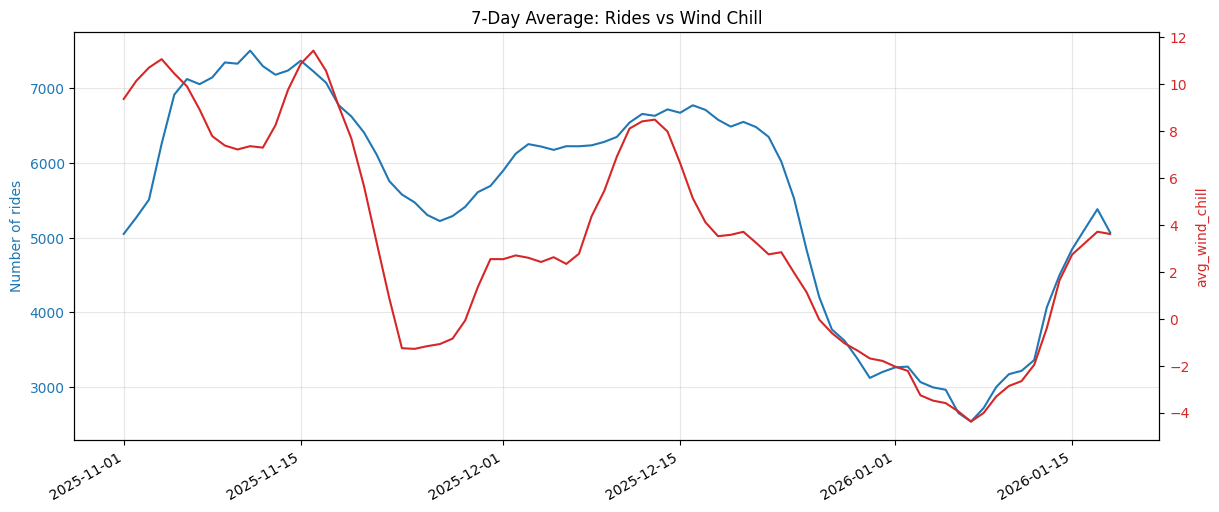

In [23]:
daily = (
    df_weather
    .groupby(['date', 'nearest_city']) 
    .agg(
        n_rides=('id', 'count'),
        avg_wind_chill=('wind_chill', 'mean'),
        avg_temp=('temperature_2m', 'mean'),   # <--- ADD THIS LINE
        avg_ride_length=('opt_route_km', 'mean'),
        avg_ride_time=('opt_route_min', 'mean'),
        total_snow_cm=('snowfall', 'sum'),
        total_rain_mm=('precipitation', 'sum'),
    )
    .sort_index()
    .reset_index()
)




for i in ['Tuebingen', 'Heidelberg', 'Reutlingen', 'Stuttgart']:
    print('City:', i)
    plot_daily_rides_vs_weather(
        df=daily[daily['nearest_city'] == i],
        date_col='date',
        rides_col='n_rides',
        weather_col='avg_wind_chill',
        window=7,
        title_raw="Daily Rides and Wind Chill",
        title_smooth="7-Day Average: Rides vs Wind Chill"
    )
#can see the overall trend of wind chill index and n_rides, however impossible to analyse all together,
#since each city has a different demand for rides based on population -> need normalization

C:\Users\erike\AppData\Local\Temp\ipykernel_102432\3971520075.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['consumption_per_km'] = df_weather['opt_route_km'] / df_weather['range_consumed']
C:\Users\erike\AppData\Local\Temp\ipykernel_102432\3971520075.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['temp_bin'] = pd.cut(df_weather['temperature_2m'], bins=np.arange(-14, 20, 2))
C:\Users\erike\AppData\Local\Temp\ipykernel_102432\3971520075.py:5: FutureWarning: The default of obs

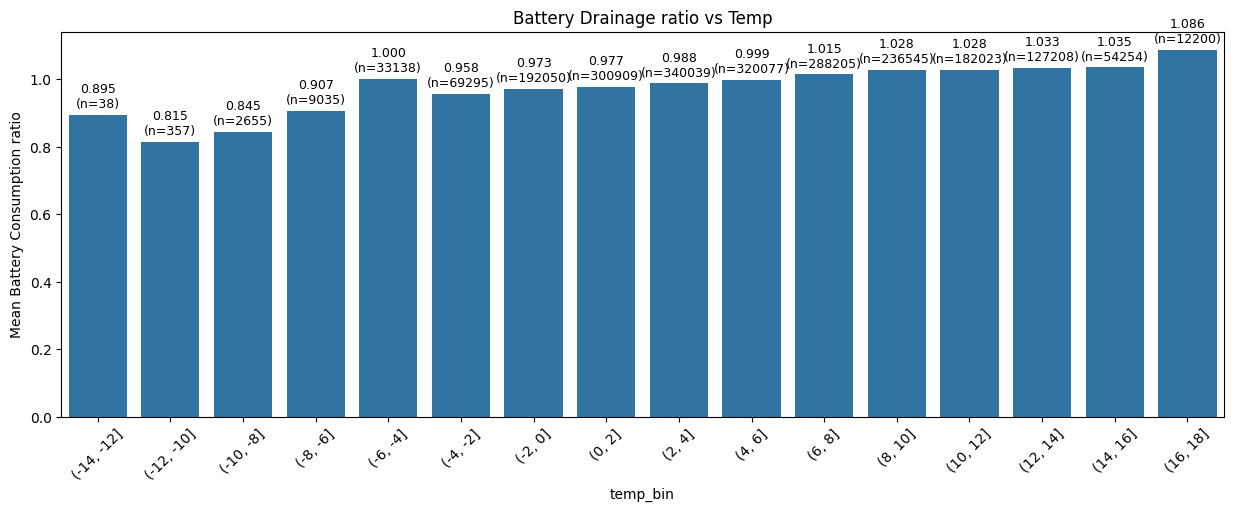

In [24]:
df_weather['consumption_per_km'] = df_weather['opt_route_km'] / df_weather['range_consumed'] 
df_weather['temp_bin'] = pd.cut(df_weather['temperature_2m'], bins=np.arange(-14, 20, 2))
temp_summary = (
    df_weather
    .groupby('temp_bin')['consumption_per_km']
    .agg(mean='mean', count='count')
    .reset_index()
)
temp_summary = temp_summary[temp_summary['count'] > 0]

plt.figure(figsize=(15,5))
ax = sns.barplot(
    x='temp_bin',
    y='mean',
    data=temp_summary
)

plt.xticks(rotation=45)
plt.ylabel('Mean Battery Consumption ratio')
plt.title('Battery Drainage ratio vs Temp')

labels = [
    f"{m:.3f}\n(n={c})"
    for m, c in zip(temp_summary['mean'], temp_summary['count'])
]

ax.bar_label(
    ax.containers[0],
    labels=labels,
    padding=3,
    fontsize=9
)

plt.show()

#also an interesting plot that shows how battery drains faster for colder temperatures, which actually
#corresponds to articles that i found online that also described 10-20% loss for every 10 degrees

## Final analysis - for the report
Assumptions for Mann-Whitney test: 
1. Independence - the rides are mostly independent of each other, having n number of rides on one day should not influence the number of rides the day after. 
2. Destributions for subsets should have a similar shape
 H0: The probability that a randomly selected ridership index from the "Dry" dataset is greater than a randomly selected ridership index from the "Wet" dataset is equal to the probability that a randomly selected ridership index from the "Wet" dataset is greater than a randomly selected ridership index from the "Dry" dataset 

(P(X Dry >Y Wet)=P(Y Wet >X Dry	)).

In [25]:
# list of cities to remove due to weird surges in demand (probably had a new provider introduced mid-december)
outlier_cities = ['Konstanz', 'Saarbrucken', 'Freiburg', 'Malmsheim']

df_weather_clean = df_weather[~df_weather['nearest_city'].isin(outlier_cities)].copy()

In [26]:
#Now let's normalize by city demand
df_counts = df_weather_clean.groupby(['nearest_city', 'date', 'hour']).agg({
    'id': 'count',
    'wind_chill': 'mean',
    'precipitation': 'mean'
}).rename(columns={'id': 'n_rides'}).reset_index()

df_counts['max_rides_hour'] = df_counts.groupby(['nearest_city', 'hour'])['n_rides'].transform('max')
df_counts['ridership_index'] = df_counts['n_rides'] / df_counts['max_rides_hour']

In [27]:
#Bin Wind Chill into 3 categories

bins = [-np.inf, 0, 5, np.inf]
labels = ['Very Cold (< 0)', 'Cold (0 - +5)', 'Moderate (> +5)']
df_counts['temp_group'] = pd.cut(df_counts['wind_chill'], bins=bins, labels=labels)


# > 0.1mm is considered "wet"
df_counts['weather_type'] = np.where(df_counts['precipitation'] > 0.1, 'Wet', 'Dry')

results = []
for temp in labels:
    subset = df_counts[df_counts['temp_group'] == temp]
    dry_data = subset[subset['weather_type'] == 'Dry']['ridership_index']
    wet_data = subset[subset['weather_type'] == 'Wet']['ridership_index']
    
    if len(dry_data) > 0 and len(wet_data) > 0:
        # stat is the U-statistic
        stat, p = mannwhitneyu(dry_data, wet_data, alternative='two-sided')
        
        avg_dry = dry_data.mean()
        avg_wet = wet_data.mean()
        index_drop = (avg_dry - avg_wet)/avg_dry * 100
        
        results.append({
            'Temp Group': temp,
            'N (Dry)': len(dry_data),
            'N (Wet)': len(wet_data),
            'U-stat': stat,  # Added U-statistic
            'Avg Index (Dry)': avg_dry,
            'Avg Index (Wet)': avg_wet,
            'Index Drop': index_drop,
            'p-value': p
        })

results_df = pd.DataFrame(results)
results_df

,Temp Group,N (Dry),N (Wet),U-stat,Avg Index (Dry),Avg Index (Wet),Index Drop,p-value
0,Very Cold (< 0),14416,1554,12858419.5,0.297655,0.247928,16.706127,8.200517e-22
1,Cold (0 - +5),11649,1512,10443068.5,0.403026,0.325147,19.323569,5.338347e-32
2,Moderate (> +5),10848,1350,9929929.0,0.487139,0.332456,31.753417,2.488337e-101


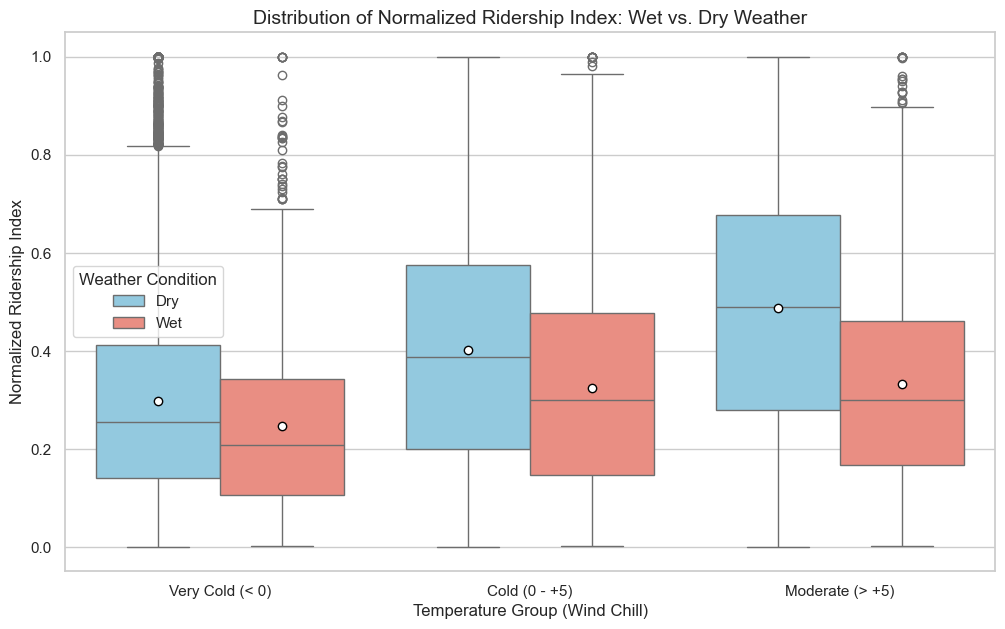

In [28]:

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

ax = sns.boxplot(
    data=df_counts, 
    x='temp_group', 
    y='ridership_index', 
    hue='weather_type',
    palette={'Dry': 'skyblue', 'Wet': 'salmon'},
    showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"6"}
)

plt.title('Distribution of Normalized Ridership Index: Wet vs. Dry Weather', fontsize=14)
plt.xlabel('Temperature Group (Wind Chill)', fontsize=12)
plt.ylabel('Normalized Ridership Index', fontsize=12)
plt.legend(title='Weather Condition')

plt.show()

# Little regression analysis

In [29]:
df_counts['is_wet'] = (df_counts['weather_type'] == 'Wet').astype(int)
df_counts['interaction'] = df_counts['wind_chill'] * df_counts['is_wet']

X = df_counts[['wind_chill', 'is_wet', 'interaction']]
X = sm.add_constant(X) 
y = df_counts['ridership_index']

model = sm.OLS(y, X).fit()


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        ridership_index   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     2197.
Date:                Mon, 02 Feb 2026   Prob (F-statistic):               0.00
Time:                        19:36:56   Log-Likelihood:                 3346.6
No. Observations:               41329   AIC:                            -6685.
Df Residuals:                   41325   BIC:                            -6651.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3572      0.001    291.937      

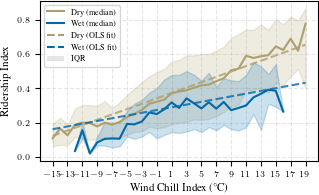

In [35]:
from tueplots import bundles
from tueplots.constants.color import rgb
import matplotlib.patches as mpatches

# Fit the model
df_counts['is_wet'] = (df_counts['weather_type'] == 'Wet').astype(int)
df_counts['interaction'] = df_counts['wind_chill'] * df_counts['is_wet']

X = df_counts[['wind_chill', 'is_wet', 'interaction']]
X = sm.add_constant(X) 
y = df_counts['ridership_index']
model = sm.OLS(y, X).fit()

# Plot
plt.style.use('default')
plt.rcParams.update(bundles.icml2024(column="half", nrows=1, ncols=1))

df_counts['temp_bin'] = df_counts['wind_chill'].round().astype(int)
bin_counts = df_counts['temp_bin'].value_counts()
valid_bins = bin_counts[bin_counts >= 20].index
df_filtered = df_counts[df_counts['temp_bin'].isin(valid_bins)].copy()

fig, ax = plt.subplots()

# Median + IQR
stats = df_filtered.groupby(['temp_bin', 'weather_type'])['ridership_index'].agg(
    median='median',
    q1=lambda x: x.quantile(0.25),
    q3=lambda x: x.quantile(0.75)
).unstack()

x_vals = stats.index

for condition in ['Dry', 'Wet']:
    if condition in stats['median'].columns:
        color = rgb.tue_gold if condition == 'Dry' else rgb.tue_blue
        ax.plot(x_vals, stats['median'][condition], color=color)
        ax.fill_between(x_vals, stats['q1'][condition], stats['q3'][condition], 
                        alpha=0.2, color=color)

# Draw regression lines from model
x_reg = np.linspace(x_vals.min(), x_vals.max(), 100)

X_dry = pd.DataFrame({'const': 1, 'wind_chill': x_reg, 'is_wet': 0, 'interaction': 0})
y_dry = model.predict(X_dry)
ax.plot(x_reg, y_dry, '--', color=rgb.tue_gold, alpha=0.8)

X_wet = pd.DataFrame({'const': 1, 'wind_chill': x_reg, 'is_wet': 1, 'interaction': x_reg})
y_wet = model.predict(X_wet)
ax.plot(x_reg, y_wet, '--', color=rgb.tue_blue, alpha=0.8)

ax.set_xlabel('Wind Chill Index (°C)')
ax.set_ylabel('Ridership Index')
ax.set_xticks(range(int(min(x_vals)), int(max(x_vals)) + 1, 2))

# Custom legend with IQR
legend_handles = [
    plt.Line2D([0], [0], color=rgb.tue_gold, label='Dry (median)'),
    plt.Line2D([0], [0], color=rgb.tue_blue, label='Wet (median)'),
    plt.Line2D([0], [0], color=rgb.tue_gold, linestyle='--', label='Dry (OLS fit)'),
    plt.Line2D([0], [0], color=rgb.tue_blue, linestyle='--', label='Wet (OLS fit)'),
    mpatches.Patch(facecolor='gray', alpha=0.2, label='IQR'),
]
ax.legend(handles=legend_handles)

ax.grid(True, linestyle='--', alpha=0.3, zorder=0)
ax.set_axisbelow(True)

plt.savefig('scooter_trend_dry_wet.pdf', bbox_inches='tight')
plt.show()
